# Initializations

## Imports

In [ ]:
import skimage
import imageio
import numpy as np
from skimage import (
    color, data, color, io, filters, measure, morphology, segmentation
)
from skimage.io import imsave, imread

import matplotlib.pyplot as plt
# from skimage.util import img_as_ubyte
import scipy.ndimage as ndi
import pandas as pd
# import seaborn as sns
import os
from PIL import Image
import deepcell
import deepcell.applications.cell_tracking
from deepcell.applications import Mesmer
import time
import glob
from PIL import Image
import re
from collections import Counter
import copy
import seaborn as sns
import colorcet as cc

In [ ]:
## Checking Versions and Conda Env
import matplotlib

print(matplotlib.__version__)
print(matplotlib.__file__)

3.5.1
/ext3/miniconda3/lib/python3.9/site-packages/matplotlib/__init__.py


## Path Setting

In [ ]:
try:
    os.chdir(SCRIPTDIR)
except:
    SCRIPTDIR = os.path.realpath('./')
# SCRIPTDIR = '/scratch/ns4964/lionnet/scripts/'

os.chdir(SCRIPTDIR)
os.chdir('../inputs/train3D/')
DATADIR = os.getcwd()

os.chdir(SCRIPTDIR)
os.chdir('../output/Mesmer/train3d')
OUTDIR = os.getcwd()


## Functions

In [ ]:
def sort_nicely( l ):
    """ Sort the given list in the way that humans expect.
    """
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]
    l.sort( key=alphanum_key )

In [ ]:
def showtif(file, zstack=0, channel=0, verbose = False):
    if os.path.isfile(file):
        skimg = io.imread(file, plugin='tifffile')
    else:
        skimg = file
    if len(skimg.shape) == 2:
        img = skimg
    if len(skimg.shape) == 3:
        img = skimg[zstack]
    if len(skimg.shape) == 4:
        img = skimg[zstack,channel]
    if verbose==True:
        if len(skimg.shape) == 2:
            print(skimg.shape,"\n", "Single layer of size {} x {}".format(skimg.shape[0],skimg.shape[1]))
        else:
            print(skimg.shape,"\n", "Showing Z-stack {} of {}".format(zstack+1, skimg.shape[0]))
    plt.axis('off')
    a = plt.imshow(img,cmap='gray')
    return a

# Bring in Data

In [ ]:
# Only pull folders from the data directory
os.chdir(DATADIR)
imgfolders = []
for file in os.listdir():
    if os.path.isdir(file):
        imgfolders.append(file)

sort_nicely(imgfolders)

# imgfolders

In [ ]:
# Create reference df for all images
imgdf = pd.DataFrame(imgfolders, columns=['imgfolder'])
imgdf['gappath']=''
imgdf['imagepath']=''
imgdf['labelpath']=''
imgdf['zlayers']=''
imgdf['x']=''
imgdf['y']=''

for index, row in imgdf.iterrows():
    indir = os.path.join(DATADIR,imgdf.iloc[index]['imgfolder'])
    imgdf.at[index,'gappath'] = os.path.join(indir,'gap.tif')
    imgdf.at[index,'imagepath'] = os.path.join(indir,'image.tif')
    imgdf.at[index,'labelpath'] = os.path.join(indir,'label.tif')
    im = imgdf['imagepath'][0]
    skimg = io.imread(im, plugin='tifffile')
    imgdf.at[index,'zlayers'] = skimg.shape[0]
    imgdf.at[index,'x'] = skimg.shape[1]
    imgdf.at[index,'y'] = skimg.shape[2]
imgdf

,imgfolder,gappath,imagepath,labelpath,zlayers,x,y
0,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
1,C1-FB323A_CSC_Rd1_2,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
2,C1-FB323A_CSC_Rd1_3,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
3,C1-FB323A_CSC_Rd1_4,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
4,C1-FB323A_CSC_Rd1_5,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
5,C1-FB323A_CSC_Rd1_6,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
6,C1-FB323A_CSC_Rd1_7,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
7,C1-FB323A_CSC_Rd1_8,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
8,C1-FB323A_CSC_Rd1_9,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
9,C1-FB323A_CSC_Rd1_10,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024


# Apply Mesmer

## Test Run

In [ ]:
i = 0

imgfile = imgdf.iloc[i]['imagepath']
imgname = imgdf.iloc[i]['imgfolder']
fakemem = imgdf.iloc[i]['gappath']

print(imgname)

C1-FB323A_CSC_Rd1_1


In [ ]:
# Using the annotation as a membrane channel

nuc_channel = imread(imgfile, plugin='tifffile')
mem_channel = imread(fakemem, plugin='tifffile')

im = np.stack((nuc_channel, mem_channel), axis=-1)
im.shape

(7, 1024, 1024, 2)

In [ ]:
app = Mesmer()
meslabel = app.predict(im,image_mpp = 0.175,compartment='nuclear')
meslabel.shape

KeyboardInterrupt: 

In [ ]:
showtif(meslabel[0,...,0])

In [ ]:
testlabel = meslabel[...,0]

showtif(testlabel, verbose=True)

In [ ]:
revtestlabel = testlabel[::-1]
showtif(revtestlabel, zstack=6,verbose=True)

In [ ]:
nuc = np.expand_dims(nuc_channel, axis=-1)
nuc.shape

In [ ]:
showtif(nuc[0,...,0])

In [ ]:
# Perform cell tracking
labeldict = deepcell.applications.cell_tracking.CellTracking().predict(nuc, meslabel)

In [ ]:
# labeldict['tracks']

In [ ]:
labeled_nuc_channel = labeldict['y_tracked'][:, :, :, 0]

In [ ]:
nucfinal = np.stack((labeled_nuc_channel, im[:, :, :, 0], im[:, :, :, 1]), axis=-1)

In [ ]:
print(nucfinal.shape)
# showtif(nuc[:,:,:,0], verbose=True)
# plt.imshow(labeldict['y_tracked'][1],cmap='gray')
nucfinal = nucfinal[...,0]
showtif(nucfinal, verbose=True)

In [ ]:
colored = color.label2rgb(nucfinal)

fig, ax = plt.subplots(1,2, figsize = (12,6))
ax[0].imshow(colored[1])
ax[1].imshow(colored[2])

# Bring image into format for comparison

## Modified Function for adapting Mesmer's labels in

In [ ]:
def CreateMesmerLabelDictv01(inputimg, mesmerlabel, reverse_direction = False):
    # Check if the object passed is an image or a file
    if os.path.isfile(inputimg):
        zstack = io.imread(inputimg, plugin='tifffile')
    else:
        zstack = inputimg

    forward = [*range(zstack.shape[0])]
    reverse = forward.copy()
    reverse.reverse()
    if reverse_direction:
        direction = reverse
    else:
        direction = forward
    origdict={}
    labdict={}
    imgdict={}
    dfdict={}
    counter = 0
    for i in direction:
        singlez = zstack[i]
        labeled = mesmerlabel[i]
        props = measure.regionprops_table(labeled, properties=('label','centroid','minor_axis_length','area','perimeter'))
        propframe = pd.DataFrame(props)
        slicename = 'z'+str(counter)
        dfdict[slicename]=propframe
        imgdict[slicename]=singlez
        labdict[slicename]=labeled
        counter += 1
    origdict["images"]=imgdict
    origdict["labels"]=labdict
    origdict["props"]=dfdict
    return origdict

In [ ]:
mestrackeddict = CreateMesmerLabelDictv01(imgfile, nucfinal)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].imshow(mestrackeddict['images']['z0'], cmap='gray')
ax[0].axis('off')
ax[1].imshow(mestrackeddict['labels']['z0'], cmap='gray')
ax[1].axis('off')

plt.tight_layout

# Apply my label tracker

In [ ]:
# Bring in the same Mesmer labeled image
testgroup = imgdf.iloc[[i]].copy()
df = testgroup
for i in df.index:
    imagename = df['imgfolder'][i]
    labelimage = meslabel[...,0]
    origlabeldict = CreateMesmerLabelDictv01(imgfile, labelimage)

print(imagename)
print(origlabeldict.keys())
showtif(labelimage)

In [ ]:
def CellTrackerv04(input_dictionary):
    origdict = input_dictionary
    # Make a new dictionary to hold the new labels
    newdict = copy.deepcopy(origdict)

    # Set up a list to move through the images in reverse.
    forwardpass =[]
    for i in newdict['images'].keys():
        forwardpass.append(i)
    reversepass = forwardpass.copy()
    reversepass.reverse()

    # Filter out all labels with area less than 50
    for i in newdict['labels'].keys():
        for j in newdict['props'][i][newdict['props'][i].area<50]['label']:
            newdict['labels'][i][newdict['labels'][i]==j]=0
        newdict['props'][i] = newdict['props'][i][newdict['props'][i].area>50]
        newdict['props'][i] = newdict['props'][i].reset_index(drop=True)

    # for i in newdict['labels'].keys():
    #     # remaininglabels = segmentation.clear_border(newdict['labels'][i], buffer_size=10)
    #     remaininglabels = newdict['labels'][i]
    #     newdict['labels'][i] = remaininglabels
    #     remaininglabels = np.unique(remaininglabels)
    #     newdict['props'][i] = newdict['props'][i][newdict['props'][i].label.isin(remaininglabels)]
    #     newdict['props'][i] = newdict['props'][i].reset_index(drop=True)

    # Make unique label ids for each label across the stack.
    labids = pd.DataFrame()
    zlayers = []
    zlabel = []
    uniqueid = []
    counter = 0
    for i in newdict['props']:
        for j in newdict['props'][i].label:
            zlayers.append(i)
            zlabel.append(j)
            counter+=1
            uniqueid.append(counter)
    labids['zlayer']=zlayers
    labids['zlabel']=zlabel
    labids['uid']=uniqueid

    # Change the regionproperties for each image and the labels for each to the new value (corresponding index of the labid frame)
    for i in labids.index:
        zlayer = labids.iloc[i]['zlayer']
        zlabel = labids.iloc[i]['zlabel']
        uid = labids.iloc[i]['uid']
        # Change the label in the props table
        corridx = newdict['props'][zlayer].label[newdict['props'][zlayer].label==zlabel].index.tolist()[0]
        newdict['props'][zlayer].at[corridx,'label']=uid
        # Change the label value in the image.
        newdict['labels'][zlayer][newdict['labels'][zlayer]==zlabel]=uid

    for z in forwardpass:
        if z == 'z6':
            continue
        startind = int(list(z)[1])
        startz = z
        endind = int(list(z)[1])+1
        endz = 'z'+str(endind)

        # Create a dataframe to keep track of label changes
        labchangedf = pd.DataFrame()
        labchangedf['startzlabels'] = newdict['props'][startz].label
        labchangedf.insert(1,'endzoverlaps',0)
        labchangedf.insert(2,'action',"none")
        labchangedf['endzoverlaps']=labchangedf['endzoverlaps'].astype(object)

        for i in newdict['props'][startz].label:
            speclabel=i
            startbinarray = newdict['labels'][startz]==speclabel
            overlappinglabels = startbinarray*newdict['labels'][endz]
            # Explicitly removing non-zero values from list of overlapping labels instead of removing the label in the first position.
            overlapid = np.unique(overlappinglabels)
            overlapid = overlapid[overlapid!=0]
            labelindex = labchangedf.index[labchangedf['startzlabels']==i].tolist()[0]
            labchangedf.at[labelindex,"endzoverlaps"]=overlapid

        labchangedf = labchangedf.drop_duplicates(subset=['startzlabels'])
        labchangedf = labchangedf.reset_index(drop=True)
        for i in labchangedf.index:
            if len(labchangedf.iloc[i]['endzoverlaps'])==0:
                labchangedf.at[i,'action']='shrinking'
            if len(labchangedf.iloc[i]['endzoverlaps'])==1:
                labchangedf.at[i,'action']='update'
            if len(labchangedf.iloc[i]['endzoverlaps'])>1:
                labchangedf.at[i,'action']='branching'

        # Check for the branching
        for i in labchangedf.index:
            if labchangedf.iloc[i]['action']!= 'branching':
                continue
            startlabel = labchangedf.iloc[i]['startzlabels']
            trueoverlaps = []
            startbin = newdict['labels'][startz]==startlabel
            for j in labchangedf.iloc[i]['endzoverlaps']:
                endbin = newdict['labels'][endz]==j
                endarea = newdict['props'][endz][newdict['props'][endz]['label']==j]['area']
                overlap = np.count_nonzero(np.logical_and(startbin,endbin))
                percentoverlap = (overlap/endarea).tolist()
                if (percentoverlap[0])>0.5:
                    trueoverlaps.append(j)
            labchangedf.at[i,"endzoverlaps"] = trueoverlaps

        for i in labchangedf.index:
            if len(labchangedf.iloc[i]['endzoverlaps'])==0:
                labchangedf.at[i,'action']='shrinking'
            if len(labchangedf.iloc[i]['endzoverlaps'])==1:
                labchangedf.at[i,'action']='update'
            if len(labchangedf.iloc[i]['endzoverlaps'])>1:
                labchangedf.at[i,'action']='branching'

        # Check for duplicates
        allvals = []
        for i in labchangedf.index:
            for j in labchangedf.iloc[i]['endzoverlaps']:
                allvals.append(j)
        d = Counter(allvals)
        d = dict((k, v) for k, v in d.items() if v > 1)
        replabs = list(d.keys())

        # Updating the labels
        for i in labchangedf.index:
            newlabel = labchangedf.iloc[i]['startzlabels']
            if labchangedf.iloc[i]['action']=='shrinking':
                continue
            for j in labchangedf.iloc[i]['endzoverlaps']:
                origlabel = j
                if origlabel in replabs:
                    continue
                origind = newdict['props'][endz][newdict['props'][endz]['label']==j].index.tolist()[0]
                newdict['props'][endz].at[origind,'label']=newlabel
                newdict['labels'][endz][newdict['labels'][endz]==origlabel]=newlabel

    for z in reversepass:
        if z == 'z0':
            continue
        startz = z
        endind = int(list(z)[1])-1
        endz = 'z'+str(endind)
        # Create a dataframe to keep track of label changes
        labchangedf = pd.DataFrame()
        labchangedf['startzlabels'] = newdict['props'][startz].label
        labchangedf.insert(1,'endzoverlaps',0)
        labchangedf.insert(2,'action',"none")
        labchangedf['endzoverlaps']=labchangedf['endzoverlaps'].astype(object)

        for i in newdict['props'][startz].label:
            speclabel=i
            startbinarray = newdict['labels'][startz]==speclabel
            overlappinglabels = startbinarray*newdict['labels'][endz]
            overlapid = np.unique(overlappinglabels)[1:]
            labelindex = labchangedf.index[labchangedf['startzlabels']==i].tolist()[0]
            labchangedf.at[labelindex,"endzoverlaps"]=overlapid
        labchangedf = labchangedf.drop_duplicates(subset=['startzlabels'])
        labchangedf = labchangedf.reset_index(drop=True)
        for i in labchangedf.index:
            if len(labchangedf.iloc[i]['endzoverlaps'])==0:
                labchangedf.at[i,'action']='shrinking'
            if len(labchangedf.iloc[i]['endzoverlaps'])==1:
                labchangedf.at[i,'action']='update'
            if len(labchangedf.iloc[i]['endzoverlaps'])>1:
                labchangedf.at[i,'action']='branching'
        # Check for the branching
        for i in labchangedf.index:
            if labchangedf.iloc[i]['action']!= 'branching':
                continue
            startlabel = labchangedf.iloc[i]['startzlabels']
            trueoverlaps = []
            startbin = newdict['labels'][startz]==startlabel
            for j in labchangedf.iloc[i]['endzoverlaps']:
                endbin = newdict['labels'][endz]==j
                endarea = newdict['props'][endz][newdict['props'][endz]['label']==j]['area']
                overlap = np.count_nonzero(np.logical_and(startbin,endbin))
                percentoverlap = (overlap/endarea).tolist()
                if (percentoverlap[0])>0.5:
                    trueoverlaps.append(j)
            labchangedf.at[i,"endzoverlaps"] = trueoverlaps

        for i in labchangedf.index:
            if len(labchangedf.iloc[i]['endzoverlaps'])==0:
                labchangedf.at[i,'action']='shrinking'
            if len(labchangedf.iloc[i]['endzoverlaps'])==1:
                labchangedf.at[i,'action']='update'
            if len(labchangedf.iloc[i]['endzoverlaps'])>1:
                labchangedf.at[i,'action']='branching'

        # Subset only to the branching labels in the reverse pass.
        # labchangedf = labchangedf[labchangedf['action']=='branching']
        # labchangedf = labchangedf.reset_index(drop=True)
        # Check for duplicates
        allvals = []
        for i in labchangedf.index:
            for j in labchangedf.iloc[i]['endzoverlaps']:
                allvals.append(j)
        d = Counter(allvals)
        d = dict((k, v) for k, v in d.items() if v > 1)
        replabs = list(d.keys())

        # Updating the labels
        for i in labchangedf.index:
            newlabel = labchangedf.iloc[i]['startzlabels']
            newlabel = labchangedf.iloc[i]['startzlabels']
            if labchangedf.iloc[i]['action']=='shrinking':
                continue
            for j in labchangedf.iloc[i]['endzoverlaps']:
                origlabel = j
                if origlabel in replabs:
                    continue
                origind = newdict['props'][endz][newdict['props'][endz]['label']==j].index.tolist()[0]
                newdict['props'][endz].at[origind,'label']=newlabel
                newdict['labels'][endz][newdict['labels'][endz]==origlabel]=newlabel

    # Check to make sure the labels and regionprops tables have same labels.
    uniquelabs=[]
    for i in newdict['labels'].keys():
        for j in np.unique(newdict['labels'][i]):
            uniquelabs.append(j)

    uniqueprops = []
    for i in newdict['props'].keys():
        for j in np.unique(newdict['props'][i].label):
            uniqueprops.append(j)

    # If they arent the same, remove the regionprops labels
    if len(np.unique(uniqueprops)+1) != len(np.unique(uniquelabs)):
        for q in newdict['props']:
            if sum(newdict['props'][q].label.isin(set(uniqueprops).difference(uniquelabs)))>0:
                newdict['props'][q] = newdict['props'][q].drop(newdict['props'][q][newdict['props'][q].label.isin(set(uniqueprops).difference(uniquelabs))].index)
                newdict['props'][q]=newdict['props'][q].reset_index(drop=True)



    # Move through the entire final z-stack and change the labels to a standardized number range.
    # Create and populate a dataframe consisting of every label across all layers in the stack.
    labids = pd.DataFrame()
    zlayers = []
    zlabel = []
    uniqueid = []
    for i in newdict['props']:
        for j in newdict['props'][i].label:
            zlayers.append(i)
            zlabel.append(j)
            if j not in uniqueid:
                uniqueid.append(j)
    labids['zlayer']=zlayers
    labids['zlabel']=zlabel

    # Step through each unique ID, locate and update the corresponding labels using the index position of the label (+1 to not overwrite bg pixels with value == 0)
    for ind, id in enumerate(uniqueid):
        new_id = ind+1
        old_id = id
        matchingidx = labids[labids['zlabel']==old_id].index.tolist()
        for j in matchingidx:
            zlayer = labids.iloc[j]['zlayer']
            zlabel = old_id
            corridx = newdict['props'][zlayer].label[newdict['props'][zlayer].label==zlabel].index.tolist()[0]
            newdict['props'][zlayer].at[corridx,'label']=new_id
            newdict['labels'][zlayer][newdict['labels'][zlayer]==zlabel]=new_id

    return newdict


In [ ]:
mytracked = CellTrackerv04(origlabeldict)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].imshow(mytracked['images']['z0'], cmap='gray')
ax[0].axis('off')
ax[1].imshow(mytracked['labels']['z0'], cmap='gray')
ax[1].axis('off')

plt.tight_layout

# Generate a comparison between the two

In [ ]:
def StackCreatorv02(input_dict):
    """Creates a dictionary of tifs based on the labels of the input dictionary. Dictionary needs to contain the keys 'labels', 'props', and 'images'. Use the CreateLabelDict function for this purpose. The returned dictionary contains a tif that is colored only by its label (shaded), a tif with the label number overlaid on top of each stack (numbered), and a tif that is colored based using a randomized colormap (colored)."""
    stackdict = {}
    # Find all of the unique labels contained in all the label images.
    uniquelabs = []
    for i in input_dict['labels'].keys():
        for j in np.unique(input_dict['labels'][i]):
            uniquelabs.append(j)
    uniquelabs = np.unique(uniquelabs)

    # Create the color map for all of the unique labels.
    pal = sns.color_palette(cc.glasbey, n_colors=len(uniquelabs), as_cmap=True)
    # Set background labels as 0
    pal[0] = '#000000'

    hexdict = {}
    for idx,hex in enumerate(pal):
        hexdict[idx]=hex

    newstack = []
    for i in input_dict['labels']:
        newstack.append(input_dict['labels'][i])
    imtoshow = np.stack(newstack)

    rgbdict = {}
    for col in hexdict.keys():
        rgbdict[col]=matplotlib.colors.hex2color(hexdict[col])

    hstacks = []
    for val in rgbdict.values():
        hstacks.append(np.hstack(val))
    rgbstacks = np.stack(hstacks)

    r = np.empty((imtoshow.shape[1], imtoshow.shape[2]))
    g = np.empty((imtoshow.shape[1], imtoshow.shape[2]))
    b = np.empty((imtoshow.shape[1], imtoshow.shape[2]))

    for idx,red in enumerate(rgbstacks[:,0]):
        r = np.where(imtoshow==idx, red,r)
    for idx,green in enumerate(rgbstacks[:,1]):
        g = np.where(imtoshow==idx, green,g)
    for idx,blue in enumerate(rgbstacks[:,2]):
        b = np.where(imtoshow==idx, blue,b)

    fullrgbim = np.stack((r,g,b), axis=3)

    # Create a stack of the numbered labels
    numlabels = []
    for h in input_dict['labels']:
        xsize = input_dict['labels'][h].shape[0]/100
        ysize = input_dict['labels'][h].shape[1]/100
        fig, ax = plt.subplots(figsize=(xsize,ysize),dpi=100)
        ax.imshow(input_dict['images'][h], cmap='gray')
        for i in input_dict['props'][h].index:
            x = input_dict['props'][h].iloc[i]["centroid-0"]
            y = input_dict['props'][h].iloc[i]["centroid-1"]
            text = input_dict['props'][h].iloc[i]["label"].astype(int)
            ax.text(y, x, text, dict(color='teal', va='center', ha='center', size = 15))
        ax.axis('off')
        plt.tight_layout(pad=0)
        fig.canvas.draw()
        numz = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        numz = numz.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        numlabels.append(numz)
        plt.close(fig)
    numberedstack = np.stack(numlabels)

    # Create a stack of the shaded labels
    shadedlabels =[]
    for i in input_dict['labels']:
        xsize = input_dict['labels'][i].shape[0]/100
        ysize = input_dict['labels'][i].shape[1]/100
        fig, ax = plt.subplots(figsize=(xsize,ysize),dpi=100)
        ax.imshow(input_dict['labels'][i], cmap='gray')
        ax.axis('off')
        plt.tight_layout(pad=0)
        fig.canvas.draw()
        shadez = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        shadez = shadez.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        shadedlabels.append(shadez)
        plt.close(fig)
        # shadedlabels.append(input_dict['labels'][i])
    shadedstack = np.stack(shadedlabels)

    # Save the outputs together to a dictionary.
    stackdict['shaded']=shadedstack
    stackdict['colored']=fullrgbim
    stackdict['numbered']=numberedstack
    return stackdict

In [ ]:
myoutlabels = StackCreatorv02(mytracked)
mesoutlabels = StackCreatorv02(mestrackeddict)

In [ ]:
mesoutlabels.keys()

In [ ]:
ztoshow = 1
fig, ax = plt.subplots(1,2, figsize=(12, 12))
ax[0].imshow(myoutlabels['colored'][ztoshow],interpolation='nearest')
ax[0].set_axis_off()

ax[1].imshow(mesoutlabels['colored'][ztoshow])
ax[1].set_axis_off()

# Save Outputs

In [ ]:
def OutputWriterv02(input_stack, output_name, output_directory, savegif = True, savetiff = True):
    if savegif:
        filenames = []
        for i in range(input_stack.shape[0]):
            fig, ax = plt.subplots(figsize=(10,10))
            ax.imshow(input_stack[i])
            ax.axis('off')
            plt.tight_layout(pad=0)

            filename = os.path.join(output_directory, f'temp_{i}.tiff')
            filenames.append(filename)
            plt.savefig(filename)
            plt.close(fig)
        # Create the GIF from the saved images.
        fp_in = os.path.join(output_directory,"temp_*.tiff")
        fp_out = os.path.join(output_directory,f"{output_name}.gif")
        imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
        img = next(imgs)  # extract first image from iterator
        img.save(fp=fp_out, format='GIF', append_images=imgs,
                 save_all=True, duration=200, loop=0)
        for filename in set(filenames):
            os.remove(filename)
    if savetiff:
        pilimages = []
        for i in range(input_stack.shape[0]):
            updatedstack = input_stack[i]*255
            updatedstack = updatedstack.astype(np.uint8)
            new = Image.fromarray(updatedstack)
            pilimages.append(new)
        outname = os.path.join(output_directory,f"{output_name}.tiff")
        pilimages[0].save(outname,format='TIFF',save_all=True,append_images=pilimages[1:])

In [ ]:
saveoutputs = True
saveoutputs = False

if saveoutputs:
    for j in myoutlabels.keys():
        labelmethod = j
        outputname = imgname+"_"+"NS_"+labelmethod+"_""label"
        OutputWriterv02(myoutlabels[j], outputname, OUTDIR)
    for j in mesoutlabels.keys():
        labelmethod = j
        outputname = imgname+"_"+"mes_"+labelmethod+"_""label"
        OutputWriterv02(mesoutlabels[j], outputname, OUTDIR)

# Batch Run

In [ ]:
testdf = imgdf.iloc[[10]]
testdf = testdf.reset_index(drop = True)

testdf

In [ ]:
os.chdir(OUTDIR)
os.getcwd()

In [ ]:
runbatch = True
# runbatch = False

saveoutputs = True
saveoutputs = False

df = imgdf
df = testdf

if runbatch:
    start_time = time.time()
    for i in df.index:
        imgfile = df.iloc[i]['imagepath']
        imgname = df.iloc[i]['imgfolder']
        fakemem = df.iloc[i]['gappath']

        # for running Mesmer
        nuc_channel = imread(imgfile, plugin='tifffile')
        mem_channel = imread(fakemem, plugin='tifffile')

        # Required to have 4 dimensions: [batch, x, y, channel], with nuclear channel first and cytoplasmic channel second."
        im = np.stack((nuc_channel, mem_channel), axis=-1)
        app = Mesmer()
        meslabel = app.predict(im,image_mpp = 0.175,compartment='nuclear')
        nuc = np.expand_dims(nuc_channel, axis=-1)

        # Perform cell tracking with Mesmer
        labeldict = deepcell.applications.cell_tracking.CellTracking().predict(nuc, meslabel)
        labeled_nuc_channel = labeldict['y_tracked'][:, :, :, 0]
        nucfinal = np.stack((labeled_nuc_channel, im[:, :, :, 0], im[:, :, :, 1]), axis=-1)
        nucfinal = nucfinal[...,0]

        # Bring in image for comparison
        mestrackeddict = CreateMesmerLabelDictv01(imgfile, nucfinal)

        # Apply my tracking on the original labeled image.
        labelimage = meslabel[...,0]

        origlabeldict = CreateMesmerLabelDictv01(imgfile, labelimage)
        mytracked = CellTrackerv04(origlabeldict)

        myoutlabels = StackCreatorv02(mytracked)
        mesoutlabels = StackCreatorv02(mestrackeddict)

        if saveoutputs:
            for j in myoutlabels.keys():
                labelmethod = j
                outputname = imgname+"_"+"NS_"+labelmethod+"_""label"
                OutputWriterv02(myoutlabels[j], outputname, OUTDIR)
            for j in mesoutlabels.keys():
                labelmethod = j
                outputname = imgname+"_"+"mes_"+labelmethod+"_""label"
                OutputWriterv02(mesoutlabels[j], outputname, OUTDIR)
    print("--- %s seconds ---" % round((time.time() - start_time),0))

--- 116.0 seconds ---


# Volumetric comparisons

## Create DF for comparison

In [ ]:
# Only pull folders from the data directory
os.chdir(DATADIR)
imgfolders = []
for file in os.listdir():
    if os.path.isdir(file):
        imgfolders.append(file)

sort_nicely(imgfolders)

In [ ]:
os.getcwd()

'/scratch/ns4964/lionnet/inputs/train3D'

In [ ]:
# Create reference df for all images
compdf = pd.DataFrame(imgfolders, columns=['imgfolder'])
compdf['gappath']=''
compdf['imagepath']=''
compdf['track_version']=''
compdf['read_direction']=''
compdf['cell_count']=''
compdf['volume']=''

In [ ]:
for index, row in compdf.iterrows():
    indir = os.path.join(DATADIR, compdf.iloc[index]['imgfolder'])
    compdf.at[index, 'gappath'] = os.path.join(indir, 'gap.tif')
    compdf.at[index,'imagepath'] = os.path.join(indir,'image.tif')
    compdf.at[index, 'track_version'] = ['Mesmer', "CellTracker"]
    compdf.at[index, 'read_direction'] = ['forward', 'reverse']

In [ ]:
compdf[0:10]

,imgfolder,gappath,imagepath,track_version,read_direction,cell_count,volume
0,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,"[Mesmer, CellTracker]","[forward, reverse]",,
1,C1-FB323A_CSC_Rd1_2,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,"[Mesmer, CellTracker]","[forward, reverse]",,
2,C1-FB323A_CSC_Rd1_3,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,"[Mesmer, CellTracker]","[forward, reverse]",,
3,C1-FB323A_CSC_Rd1_4,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,"[Mesmer, CellTracker]","[forward, reverse]",,
4,C1-FB323A_CSC_Rd1_5,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,"[Mesmer, CellTracker]","[forward, reverse]",,
5,C1-FB323A_CSC_Rd1_6,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,"[Mesmer, CellTracker]","[forward, reverse]",,
6,C1-FB323A_CSC_Rd1_7,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,"[Mesmer, CellTracker]","[forward, reverse]",,
7,C1-FB323A_CSC_Rd1_8,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,"[Mesmer, CellTracker]","[forward, reverse]",,
8,C1-FB323A_CSC_Rd1_9,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,"[Mesmer, CellTracker]","[forward, reverse]",,
9,C1-FB323A_CSC_Rd1_10,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,"[Mesmer, CellTracker]","[forward, reverse]",,


In [ ]:
compdf = compdf.explode('track_version').reset_index(drop=True)
compdf = compdf.explode('read_direction').reset_index(drop=True)
compdf[0:10]

,imgfolder,gappath,imagepath,track_version,read_direction,cell_count,volume
0,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,Mesmer,forward,,
1,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,Mesmer,reverse,,
2,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,CellTracker,forward,,
3,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,CellTracker,reverse,,
4,C1-FB323A_CSC_Rd1_2,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,Mesmer,forward,,
5,C1-FB323A_CSC_Rd1_2,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,Mesmer,reverse,,
6,C1-FB323A_CSC_Rd1_2,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,CellTracker,forward,,
7,C1-FB323A_CSC_Rd1_2,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,CellTracker,reverse,,
8,C1-FB323A_CSC_Rd1_3,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,Mesmer,forward,,
9,C1-FB323A_CSC_Rd1_3,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,Mesmer,reverse,,


## Run Batch

In [ ]:
# Single Image
imgindex = [2]
testims = imgdf.iloc[imgindex].imgfolder.values[0]
testgroup = compdf[compdf.imgfolder==testims]

# Multiple Images
testims = list(imgdf.iloc[2:4].imgfolder)
testgroup = compdf[compdf.imgfolder.isin(testims)]

print(testims)
testgroup

['C1-FB323A_CSC_Rd1_3', 'C1-FB323A_CSC_Rd1_4']


,imgfolder,gappath,imagepath,track_version,read_direction,cell_count,volume
8,C1-FB323A_CSC_Rd1_3,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,Mesmer,forward,,
9,C1-FB323A_CSC_Rd1_3,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,Mesmer,reverse,,
10,C1-FB323A_CSC_Rd1_3,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,CellTracker,forward,,
11,C1-FB323A_CSC_Rd1_3,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,CellTracker,reverse,,
12,C1-FB323A_CSC_Rd1_4,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,Mesmer,forward,,
13,C1-FB323A_CSC_Rd1_4,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,Mesmer,reverse,,
14,C1-FB323A_CSC_Rd1_4,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,CellTracker,forward,,
15,C1-FB323A_CSC_Rd1_4,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,CellTracker,reverse,,


In [ ]:
# Test run the pipeline

# Loop to run single image through all
runtest = True
runtest = False

df = testgroup
df = compdf

start_time = time.time()
if runtest:
    for i in df.index:
        try:
            imgfile = df['imagepath'][i]
            imgname = df['imgfolder'][i]
            fakemem = df['gappath'][i]
            version = df['track_version'][i]
            direction = df['read_direction'][i]

            # for running Mesmer
            nuc_channel = imread(imgfile, plugin='tifffile')
            mem_channel = imread(fakemem, plugin='tifffile')
            # Required to have 4 dimensions: [batch, x, y, channel], with nuclear channel first and cytoplasmic channel second."
            im = np.stack((nuc_channel, mem_channel), axis=-1)
            app = Mesmer()
            meslabel = app.predict(im,image_mpp = 0.175,compartment='nuclear')
            nuc = np.expand_dims(nuc_channel, axis=-1)

            if version == 'Mesmer':
                if direction == 'forward':
                    mesdict = deepcell.applications.cell_tracking.CellTracking().predict(nuc, meslabel)
                    labeled_nuc_channel = mesdict['y_tracked'][:, :, :, 0]
                    nucfinal = np.stack((labeled_nuc_channel, im[:, :, :, 0], im[:, :, :, 1]), axis=-1)
                    nucfinal = nucfinal[...,0]
                    labeldict = CreateMesmerLabelDictv01(imgfile, nucfinal)
                if direction == 'reverse':
                    # Reverse the nuclear image and the label stack
                    nuc = nuc[::-1]
                    meslabel = meslabel[::-1]
                    mesdict = deepcell.applications.cell_tracking.CellTracking().predict(nuc, meslabel)
                    labeled_nuc_channel = mesdict['y_tracked'][:, :, :, 0]
                    nucfinal = np.stack((labeled_nuc_channel, im[:, :, :, 0], im[:, :, :, 1]), axis=-1)
                    nucfinal = nucfinal[...,0]
                    labeldict = CreateMesmerLabelDictv01(imgfile, nucfinal)

            if version =='CellTracker':
                labelimage = meslabel[...,0]

                if direction == 'forward':
                    origlabeldict = CreateMesmerLabelDictv01(imgfile, labelimage)
                if direction == 'reverse':
                    origlabeldict = CreateMesmerLabelDictv01(imgfile, labelimage, reverse_direction = True)

                labeldict = CellTrackerv04(origlabeldict)

            newstack = []
            for j in labeldict['labels']:
                newstack.append(labeldict['labels'][j])
            newims = np.stack(newstack)

            props = pd.DataFrame(measure.regionprops_table(newims, properties=('label','area')))

            df.at[i,'cell_count'] = len(props['label'])
            df.at[i,'volume'] = props['area'].mean()

        except:
            print('Error')
            continue


In [ ]:
print("--- %s seconds ---" % round((time.time() - start_time),0))

df

--- 0.0 seconds ---


,imgfolder,gappath,imagepath,track_version,read_direction,cell_count,volume
0,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,Mesmer,forward,,
1,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,Mesmer,reverse,,
2,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,CellTracker,forward,,
3,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,CellTracker,reverse,,
4,C1-FB323A_CSC_Rd1_2,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,Mesmer,forward,,
...,...,...,...,...,...,...,...
87,C1-FB323A_CSC_Rd1_22,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,CellTracker,reverse,,
88,C1-FB323A_CSC_Rd1_23,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,Mesmer,forward,,
89,C1-FB323A_CSC_Rd1_23,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,Mesmer,reverse,,
90,C1-FB323A_CSC_Rd1_23,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,CellTracker,forward,,


In [ ]:
savecsv = True
savecsv = False

if savecsv:
    df.to_csv(os.path.join(OUTDIR,"MesmerRunComps.csv"))

In [ ]:
OUTDIR

'/scratch/ns4964/lionnet/output/Mesmer/train3d'

## Plotting

In [66]:
csvpath = os.path.join(OUTDIR,'Label Comparison/')

In [67]:
# Make plotting df
os.chdir(csvpath)
plotdf = pd.read_csv('MesmerRunComps.csv', index_col = 0)

In [68]:
plotdf=plotdf.rename(columns ={'imgfolder':'img'})

In [69]:
# Make plotting df and remove imgs with any empty values.
emptyimgs = plotdf[plotdf['cell_count']=='']['img'].tolist()
plotdf = plotdf[plotdf['img'].isin(emptyimgs)==False].reset_index(drop=True)
len(emptyimgs)

0

In [70]:
plotdf.dropna()
plotdf.reset_index(drop=True)

,img,gappath,imagepath,track_version,read_direction,cell_count,volume
0,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,Mesmer,forward,273,8268.564103
1,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,Mesmer,reverse,274,8238.386861
2,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,CellTracker,forward,183,12335.071038
3,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,CellTracker,reverse,180,12540.655556
4,C1-FB323A_CSC_Rd1_2,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,Mesmer,forward,298,7809.684564
...,...,...,...,...,...,...,...
87,C1-FB323A_CSC_Rd1_22,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,CellTracker,reverse,124,17174.233871
88,C1-FB323A_CSC_Rd1_23,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,Mesmer,forward,260,8786.203846
89,C1-FB323A_CSC_Rd1_23,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,Mesmer,reverse,261,8752.540230
90,C1-FB323A_CSC_Rd1_23,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,CellTracker,forward,131,17438.267176


### CellTracker Internal

In [71]:
ctforward = plotdf[(plotdf['track_version']=='CellTracker') & (plotdf['read_direction']=='forward')]
ctreverse = plotdf[(plotdf['track_version']=='CellTracker') & (plotdf['read_direction']=='reverse')]

Text(0.5, 1.0, 'Histogram of Cells by Count')

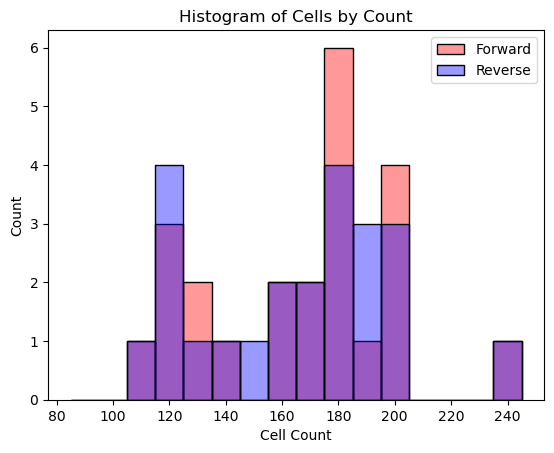

In [97]:
plt.style.use('default')
sns.histplot(x='cell_count', data = ctforward, color = 'red', bins = 18, binwidth=10, binrange=[85,240], alpha = 0.4, label='Forward')
sns.histplot(x='cell_count', data = ctreverse, color = 'blue', bins = 14, binwidth=10,binrange=[85,240],  alpha = 0.4, label = 'Reverse')
plt.legend()
plt.xlabel(r"Cell Count")
plt.title('Histogram of Cells by Count')

Text(0.5, 1.0, 'Histogram of Cells by Volume')

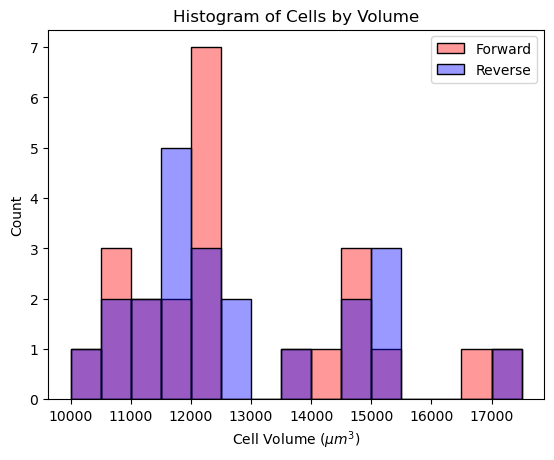

In [105]:
plt.style.use('default')
sns.histplot(x='volume', data = ctforward, color = 'red', bins = 18, binwidth=500,binrange=[10000,17500], alpha = 0.4, label='Forward')
sns.histplot(x='volume', data = ctreverse, color = 'blue', bins = 14,
             binwidth=500,binrange=[10000,17500],
             alpha = 0.4, label = 'Reverse')
plt.legend()
plt.xlabel(r"Cell Volume ($\mu m^3$)")
plt.title('Histogram of Cells by Volume')

In [137]:
ctonly = plotdf[plotdf['track_version']=='CellTracker']
ctonly.head()

,img,gappath,imagepath,track_version,read_direction,cell_count,volume
2,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,CellTracker,forward,183,12335.071038
3,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,CellTracker,reverse,180,12540.655556
6,C1-FB323A_CSC_Rd1_2,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,CellTracker,forward,199,11694.904523
7,C1-FB323A_CSC_Rd1_2,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,CellTracker,reverse,201,11578.537313
10,C1-FB323A_CSC_Rd1_3,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,CellTracker,forward,241,10759.672199


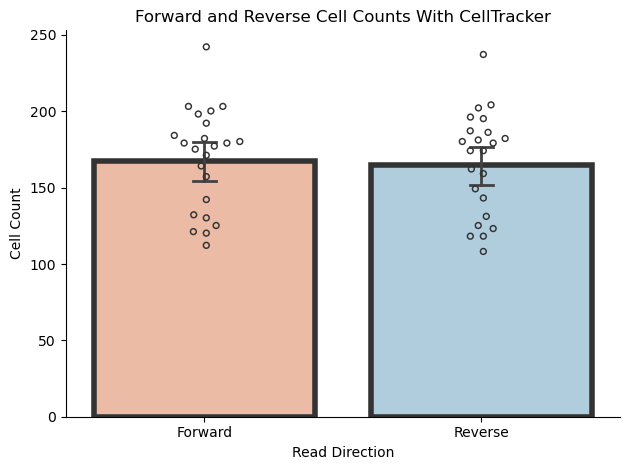

In [151]:
plt.style.use('default')

g = sns.barplot(x='read_direction',
            y='cell_count',
            data=ctonly,
            # fill=False,
            palette='RdBu',
            capsize=0.08,
            errwidth=2,
            linewidth = 4,
            edgecolor="0.2",
            )
g = sns.swarmplot(x='read_direction',
              y='cell_count',
              data=ctonly,
              # palette = colors,
              # palette = 'black',
              color = '0.2',
              s=8,
              marker="$\circ$",

              )

g.set(xticklabels = (['Forward','Reverse']))
plt.xlabel("Read Direction", size=10)
plt.ylabel("Cell Count", size=10)
plt.title("Forward and Reverse Cell Counts With CellTracker", size=12)
plt.xticks()
plt.yticks()
plt.tight_layout()

sns.despine()

In [154]:
# Metrics
from scipy.stats import sem
print("CellTracker Forward Cell Count:", ctonly[ctonly['read_direction'] == 'forward']['cell_count'].mean())
print("SEM for CellTracker Forward:", sem(ctonly[ctonly['read_direction'] == 'forward']['cell_count']))
print("CellTracker Reverse Cell Count:", ctonly[ctonly['read_direction'] == 'reverse']['cell_count'].mean())
print("SEM for CellTracker Reverse:", sem(ctonly[ctonly['read_direction'] == 'reverse']['cell_count']))

CellTracker Forward Cell Count: 167.17391304347825
SEM for CellTracker Forward: 6.951739957337223
CellTracker Reverse Cell Count: 164.7826086956522
SEM for CellTracker Reverse: 7.0214117815496


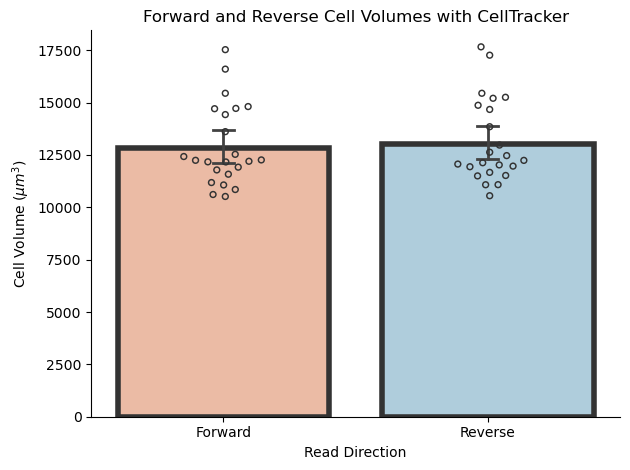

In [150]:
plt.style.use('default')

g = sns.barplot(x='read_direction',
                y='volume',
                data=ctonly,
                # fill=False,
                palette='RdBu',
                capsize=0.08,
                errwidth=2,
                linewidth = 4,
                edgecolor="0.2",
                )
g = sns.swarmplot(x='read_direction',
                  y='volume',
                  data=ctonly,
                  # palette = colors,
                  # palette = 'black',
                  color = '0.2',
                  s=8,
                  marker="$\circ$",

                  )

g.set(xticklabels = (['Forward','Reverse']))
plt.xlabel("Read Direction", size=10)
plt.ylabel(r"Cell Volume ($\mu m^3$)", size=10)
plt.title("Forward and Reverse Cell Volumes with CellTracker", size=12)
plt.xticks()
plt.yticks()
plt.tight_layout()

sns.despine()

In [155]:
# Metrics
print("CellTracker Forward Volume: ", ctonly[ctonly['read_direction'] == 'forward']['volume'].mean())
print("SEM for CellTracker Forward Volume:", sem(ctonly[ctonly['read_direction'] == 'forward']['volume']))
print("CellTracker Reverse Volume:", ctonly[ctonly['read_direction'] == 'reverse']['volume'].mean())
print("SEM for CellTracker Reverse Volume:", sem(ctonly[ctonly['read_direction'] == 'reverse']['volume']))

CellTracker Forward Volume:  12839.006666880075
SEM for CellTracker Forward Volume: 404.4744762867366
CellTracker Reverse Volume: 13043.195367792494
SEM for CellTracker Reverse Volume: 416.6204622623716


In [111]:
diffs = pd.pivot_table(plotdf,
                       index=['img','track_version'],
                       # columns = ['img','track_version'],
                       values = ['cell_count','volume'],
                       aggfunc = 'diff'
                       )
diffs

,cell_count,volume
1,1,-30.177241
3,-3,205.584517
5,-3,79.420521
7,2,-116.367209
9,-9,185.736005
11,-5,227.959157
13,4,-119.382981
15,4,-261.822547
17,-12,348.440885
19,2,-134.505201


In [112]:
aggdf = plotdf[plotdf.index.isin(diffs.index)]
aggdf

,img,gappath,imagepath,track_version,read_direction,cell_count,volume
1,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,Mesmer,reverse,274,8238.386861
3,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,CellTracker,reverse,180,12540.655556
5,C1-FB323A_CSC_Rd1_2,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,Mesmer,reverse,295,7889.105085
7,C1-FB323A_CSC_Rd1_2,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,CellTracker,reverse,201,11578.537313
9,C1-FB323A_CSC_Rd1_3,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,Mesmer,reverse,350,7408.802857
11,C1-FB323A_CSC_Rd1_3,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,CellTracker,reverse,236,10987.631356
13,C1-FB323A_CSC_Rd1_4,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,Mesmer,reverse,273,8028.505495
15,C1-FB323A_CSC_Rd1_4,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,CellTracker,reverse,185,11847.470270
17,C1-FB323A_CSC_Rd1_5,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,Mesmer,reverse,268,8130.287313
19,C1-FB323A_CSC_Rd1_5,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,CellTracker,reverse,181,12038.215470


In [113]:
aggdf = aggdf.drop(plotdf.columns[4:], axis=1)
aggdf

,img,gappath,imagepath,track_version
1,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,Mesmer
3,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,CellTracker
5,C1-FB323A_CSC_Rd1_2,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,Mesmer
7,C1-FB323A_CSC_Rd1_2,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,CellTracker
9,C1-FB323A_CSC_Rd1_3,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,Mesmer
11,C1-FB323A_CSC_Rd1_3,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,CellTracker
13,C1-FB323A_CSC_Rd1_4,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,Mesmer
15,C1-FB323A_CSC_Rd1_4,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,CellTracker
17,C1-FB323A_CSC_Rd1_5,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,Mesmer
19,C1-FB323A_CSC_Rd1_5,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,CellTracker


In [114]:
aggdf = aggdf.join(diffs)

In [115]:
aggdf.volume = abs(aggdf.volume)
aggdf.cell_count = abs(aggdf.cell_count)

In [116]:
aggdf

,img,gappath,imagepath,track_version,cell_count,volume
1,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,Mesmer,1,30.177241
3,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,CellTracker,3,205.584517
5,C1-FB323A_CSC_Rd1_2,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,Mesmer,3,79.420521
7,C1-FB323A_CSC_Rd1_2,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,CellTracker,2,116.367209
9,C1-FB323A_CSC_Rd1_3,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,Mesmer,9,185.736005
11,C1-FB323A_CSC_Rd1_3,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,CellTracker,5,227.959157
13,C1-FB323A_CSC_Rd1_4,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,Mesmer,4,119.382981
15,C1-FB323A_CSC_Rd1_4,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,CellTracker,4,261.822547
17,C1-FB323A_CSC_Rd1_5,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,Mesmer,12,348.440885
19,C1-FB323A_CSC_Rd1_5,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,CellTracker,2,134.505201


In [117]:
cellchange = plotdf.cell_count.pct_change()
cellchange = cellchange[cellchange.index.isin(aggdf.index)]
aggdf = aggdf.join(cellchange,rsuffix='_pct')

volchange = plotdf.volume.pct_change()
volchange = volchange[volchange.index.isin(aggdf.index)]
aggdf = aggdf.join(volchange,rsuffix='_pct')

In [118]:
aggdf.cell_count_pct = abs(aggdf.cell_count_pct)
aggdf.volume_pct = abs(aggdf.volume_pct)
aggdf

,img,gappath,imagepath,track_version,cell_count,volume,cell_count_pct,volume_pct
1,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,Mesmer,1,30.177241,0.003663,0.003650
3,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,CellTracker,3,205.584517,0.016393,0.016667
5,C1-FB323A_CSC_Rd1_2,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,Mesmer,3,79.420521,0.010067,0.010169
7,C1-FB323A_CSC_Rd1_2,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,CellTracker,2,116.367209,0.010050,0.009950
9,C1-FB323A_CSC_Rd1_3,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,Mesmer,9,185.736005,0.025070,0.025714
11,C1-FB323A_CSC_Rd1_3,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,CellTracker,5,227.959157,0.020747,0.021186
13,C1-FB323A_CSC_Rd1_4,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,Mesmer,4,119.382981,0.014870,0.014652
15,C1-FB323A_CSC_Rd1_4,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,CellTracker,4,261.822547,0.022099,0.021622
17,C1-FB323A_CSC_Rd1_5,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,Mesmer,12,348.440885,0.042857,0.044776
19,C1-FB323A_CSC_Rd1_5,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,CellTracker,2,134.505201,0.011173,0.011050


### Mesmer vs. CT Relative Change

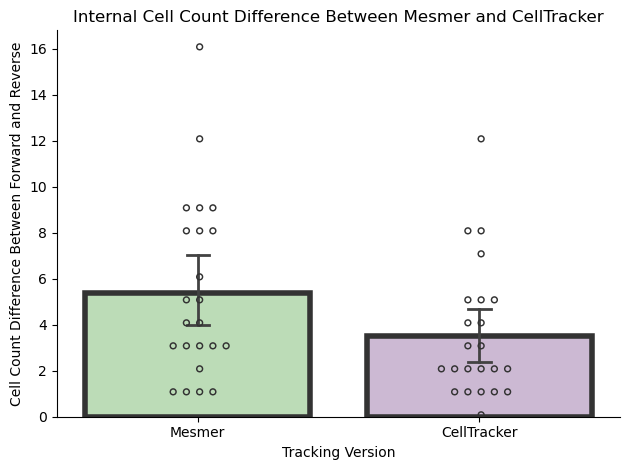

In [119]:
plt.style.use('default')

colors = ['#af84cd','#ff7b8b']

sns.barplot(x='track_version',
            y='cell_count',
            data=aggdf,
            # fill=False,
            palette='PRGn_r',
            capsize=0.08,
            errwidth=2,
            linewidth = 4,
            edgecolor="0.2"
            )
sns.swarmplot(x='track_version',
              y='cell_count',
              data=aggdf,
              # palette = colors,
              # palette = 'black',
              color = '0.2',
              s=8,
              marker="$\circ$",
              )

plt.xlabel("Tracking Version", size=10)
plt.ylabel("Cell Count Difference Between Forward and Reverse", size=10)
plt.title("Internal Cell Count Difference Between Mesmer and CellTracker", size=12)
plt.xticks()
plt.yticks()
plt.tight_layout()

sns.despine()

In [120]:
# Metrics
from scipy.stats import sem

print("Mesmer Mean Cell Count Difference:",aggdf[aggdf['track_version'] == 'Mesmer']['cell_count'].mean())
print("Mesmer SEM for Cell Count Difference:", sem(aggdf[aggdf['track_version'] == 'Mesmer']['cell_count']))
print("CellTracker Mean Cell Count Difference:",aggdf[aggdf['track_version'] == 'CellTracker']['cell_count'].mean())
print("CellTracker SEM for Cell Count Difference:", sem(aggdf[aggdf['track_version'] == 'CellTracker']['cell_count']))

Mesmer Mean Cell Count Difference: 5.391304347826087
Mesmer SEM for Cell Count Difference: 0.8166719566156664
CellTracker Mean Cell Count Difference: 3.5217391304347827
CellTracker SEM for Cell Count Difference: 0.612354895992361


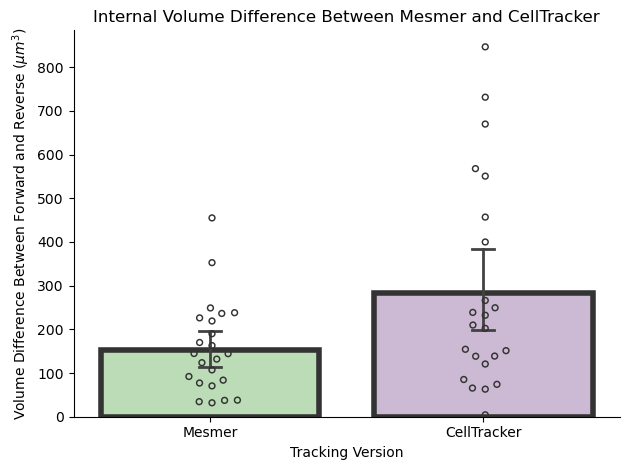

In [121]:
plt.style.use('default')

colors = ['#af84cd','#ff7b8b']

sns.barplot(x='track_version',
            y='volume',
            data=aggdf,
            # fill=False,
            palette='PRGn_r',
            capsize=0.08,
            errwidth=2,
            linewidth = 4,
            edgecolor="0.2"
            )
sns.swarmplot(x='track_version',
              y='volume',
              data=aggdf,
              # palette = colors,
              # palette = 'black',
              color = '0.2',
              s=8,
              marker="$\circ$",
              )

plt.xlabel("Tracking Version", size=10)
plt.ylabel(r"Volume Difference Between Forward and Reverse ($\mu m^3$)", size=10)
plt.title("Internal Volume Difference Between Mesmer and CellTracker", size=12)
plt.xticks()
plt.yticks()
plt.tight_layout()

sns.despine()

In [122]:
# Metrics
print("Mesmer Mean Volume Difference:",aggdf[aggdf['track_version'] == 'Mesmer']['volume'].mean())
print("Mesmer SEM for Volume Difference:", sem(aggdf[aggdf['track_version'] == 'Mesmer']['volume']))
print("CellTracker Mean Volume Difference:",aggdf[aggdf['track_version'] == 'CellTracker']['volume'].mean())
print("CellTracker SEM for Volume Difference:", sem(aggdf[aggdf['track_version'] == 'CellTracker']['volume']))

Mesmer Mean Volume Difference: 152.95760161117659
Mesmer SEM for Volume Difference: 22.02995026281485
CellTracker Mean Volume Difference: 283.46155687338756
CellTracker SEM for Volume Difference: 49.52035079464761


### Raw Counts

In [123]:
plotdf.head()

,img,gappath,imagepath,track_version,read_direction,cell_count,volume
0,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,Mesmer,forward,273,8268.564103
1,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,Mesmer,reverse,274,8238.386861
2,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,CellTracker,forward,183,12335.071038
3,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,CellTracker,reverse,180,12540.655556
4,C1-FB323A_CSC_Rd1_2,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,Mesmer,forward,298,7809.684564


In [124]:
means = pd.pivot_table(plotdf,
                       index=['img','track_version'],
                       # columns = ['img','track_version'],
                       values = ['cell_count','volume'],
                       aggfunc = 'mean'
                       )
means = means.reset_index(drop=False)

In [125]:
means

,img,track_version,cell_count,volume
0,C1-FB323A_CSC_Rd1_1,CellTracker,181.5,12437.863297
1,C1-FB323A_CSC_Rd1_1,Mesmer,273.5,8253.475482
2,C1-FB323A_CSC_Rd1_10,CellTracker,198.0,11203.900837
3,C1-FB323A_CSC_Rd1_10,Mesmer,283.5,7821.777416
4,C1-FB323A_CSC_Rd1_11,CellTracker,152.0,10709.791753
5,C1-FB323A_CSC_Rd1_11,Mesmer,226.5,7183.042859
6,C1-FB323A_CSC_Rd1_12,CellTracker,141.5,11450.206573
7,C1-FB323A_CSC_Rd1_12,Mesmer,240.5,6737.459833
8,C1-FB323A_CSC_Rd1_13,CellTracker,120.5,12517.838675
9,C1-FB323A_CSC_Rd1_13,Mesmer,222.0,6791.065073


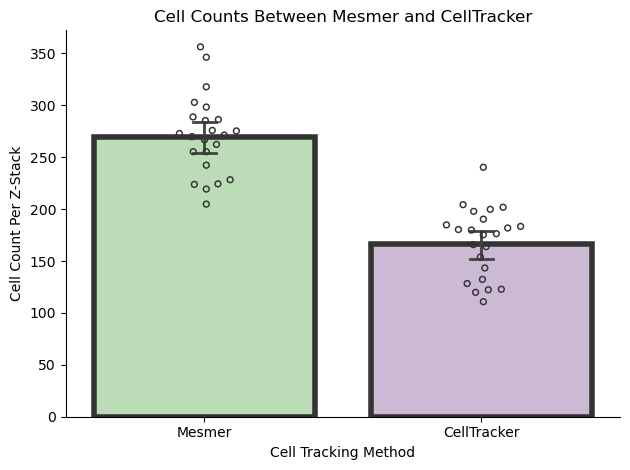

In [130]:
plt.style.use('default')

colors = ['#af84cd','#ff7b8b']

sns.barplot(x='track_version',
            y='cell_count',
            data=means,
            # fill=False,
            palette='PRGn_r',
            capsize=0.08,
            errwidth=2,
            linewidth = 4,
            edgecolor="0.2",
            order = ["Mesmer", "CellTracker"]
            )
sns.swarmplot(x='track_version',
              y='cell_count',
              data=means,
              # palette = colors,
              # palette = 'black',
              color = '0.2',
              s=8,
              marker="$\circ$",
              order = ["Mesmer", "CellTracker"]
              )

plt.xlabel("Cell Tracking Method", size=10)
plt.ylabel("Cell Count Per Z-Stack", size=10)
plt.title("Cell Counts Between Mesmer and CellTracker", size=12)
plt.xticks()
plt.yticks()
plt.tight_layout()

sns.despine()

In [128]:
# Metrics
print("Mesmer Mean Volume Difference:",means[means['track_version'] == 'Mesmer']['cell_count'].mean())
print("Mesmer SEM for Volume Difference:", sem(means[means['track_version'] == 'Mesmer']['cell_count']))
print("CellTracker Mean Volume Difference:",means[means['track_version'] == 'CellTracker']['cell_count'].mean())
print("CellTracker SEM for Volume Difference:", sem(means[means['track_version'] == 'CellTracker']['cell_count']))

Mesmer Mean Volume Difference: 269.04347826086956
Mesmer SEM for Volume Difference: 8.0009209600502
CellTracker Mean Volume Difference: 165.97826086956522
CellTracker SEM for Volume Difference: 6.974507382045211


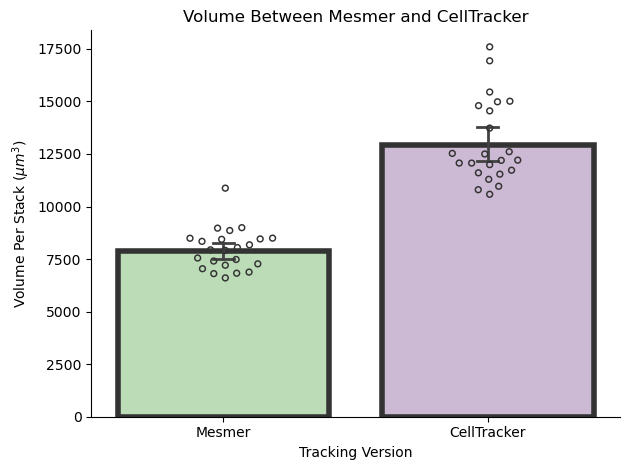

In [132]:
plt.style.use('default')

colors = ['#af84cd','#ff7b8b']

sns.barplot(x='track_version',
            y='volume',
            data=means,
            # fill=False,
            palette='PRGn_r',
            capsize=0.08,
            errwidth=2,
            linewidth = 4,
            edgecolor="0.2",
            order = ["Mesmer", "CellTracker"]
            )
sns.swarmplot(x='track_version',
              y='volume',
              data=means,
              # palette = colors,
              # palette = 'black',
              color = '0.2',
              s=8,
              marker="$\circ$",
              order = ["Mesmer", "CellTracker"]
              )

plt.xlabel("Tracking Version", size=10)
plt.ylabel(r"Volume Per Stack ($\mu m^3$)", size=10)
plt.title("Volume Between Mesmer and CellTracker", size=12)
plt.xticks()
plt.yticks()
plt.tight_layout()

sns.despine()

In [129]:
print("Mesmer Mean Volume Difference:",means[means['track_version'] == 'Mesmer']['volume'].mean())
print("Mesmer SEM for Volume Difference:", sem(means[means['track_version'] == 'Mesmer']['volume']))
print("CellTracker Mean Volume Difference:",means[means['track_version'] == 'CellTracker']['volume'].mean())
print("CellTracker SEM for Volume Difference:", sem(means[means['track_version'] == 'CellTracker']['volume']))

Mesmer Mean Volume Difference: 7869.970882639204
Mesmer SEM for Volume Difference: 202.9291675676294
CellTracker Mean Volume Difference: 12941.101017336283
CellTracker SEM for Volume Difference: 409.3088693444014


# 3D Images

## Mesmer 3D Images

In [97]:
imgindex = 10
testgroup = imgdf.iloc[[imgindex]].copy()
# inputimg = testgroup['labelpath'][0]

testgroup.imgfolder

10    C1-FB323A_CSC_Rd1_11
Name: imgfolder, dtype: object

In [98]:
# Loop to run single image through all
runtest = True # 72 seconds
# runtest = False

df = testgroup

start_time = time.time()
if runtest:
    for i in df.index:
        imgfile = df['imagepath'][i]
        imgname = df['imgfolder'][i]
        fakemem = df['gappath'][i]
        print('Starting:',imgname)

        # for running Mesmer
        nuc_channel = imread(imgfile, plugin='tifffile')
        mem_channel = imread(fakemem, plugin='tifffile')

        # Required to have 4 dimensions: [batch, x, y, channel], with nuclear channel first and cytoplasmic channel second."
        im = np.stack((nuc_channel, mem_channel), axis=-1)
        app = Mesmer()
        meslabel = app.predict(im,image_mpp = 0.175,compartment='nuclear')
        nuc = np.expand_dims(nuc_channel, axis=-1)

        # Perform cell tracking with Mesmer
        labeldict = deepcell.applications.cell_tracking.CellTracking().predict(nuc, meslabel)
        labeled_nuc_channel = labeldict['y_tracked'][:, :, :, 0]
        nucfinal = np.stack((labeled_nuc_channel, im[:, :, :, 0], im[:, :, :, 1]), axis=-1)
        nucfinal = nucfinal[...,0]

        forwardlabeldict = CreateMesmerLabelDictv01(imgfile, nucfinal)
        reverselabeldict = CreateMesmerLabelDictv01(imgfile, nucfinal, reverse_direction = True)
        # newlabelsforward = CellTrackerv04(forwardlabeldict)
        # newlabelsreverse = CellTrackerv04(reverselabeldict)


print("--- %s seconds ---" % round((time.time() - start_time),0))

Starting: C1-FB323A_CSC_Rd1_11


--- 31.0 seconds ---


In [99]:
newlabelsforward = forwardlabeldict
newlabelsreverse = reverselabeldict

newlabelsforward.keys()

dict_keys(['images', 'labels', 'props'])

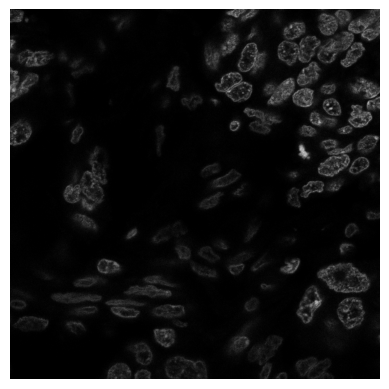

In [100]:
showtif(newlabelsforward['images']['z2'])

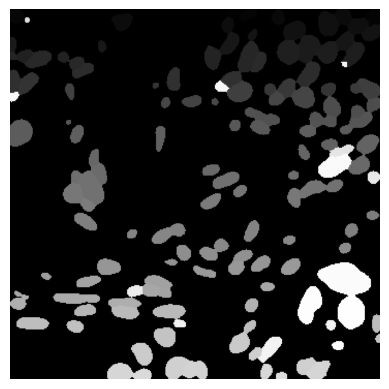

In [101]:
showtif(newlabelsforward['labels']['z2'])

In [ ]:
## Forward direction
imstack = StackCreatorv02(newlabelsforward)
dftoqc = newlabelsforward

uniquelabs = []
for i in dftoqc['labels'].keys():
    for j in np.unique(dftoqc['labels'][i]):
        uniquelabs.append(j)
print(len(np.unique(uniquelabs)), np.max(uniquelabs))

uniqueprops = []
for i in dftoqc['props'].keys():
    for j in np.unique(dftoqc['props'][i].label):
        uniqueprops.append(j)
print(len(np.unique(uniqueprops)), np.max(uniqueprops))

Counter(uniqueprops) == Counter([value for value in uniquelabs if value != 0])

# From stackcreator function. Creates a random color for each label that can be referenced throughout the stack. Format is in RGB (3 columns per label, each value is between 0 and 1).

uniquelabs = np.unique(uniquelabs)
# Create the color map for all of the unique labels.
randcols = np.random.random((len(uniquelabs), 3))
# Set background labels as 0
randcols[0] = 0
print(len(uniquelabs))
len(randcols)
# randcols
pal = sns.color_palette(cc.glasbey, n_colors=len(uniquelabs), as_cmap=True)
pal[0] = '#000000'
print(len(pal))
sns.palplot(pal)
# Create a separate stack from just the label images (pull them from the dictionary)
newstack = []
for i in dftoqc['labels']:
    newstack.append(dftoqc['labels'][i])
forims = np.stack(newstack)
forims.shape
len(np.unique(forims))
# Make a colormap for matplotlib from the random colors generated.
mycmap = matplotlib.colors.ListedColormap(pal)  # randcols
# mycmap

# Convert the label colors to rgba values represented as hex codes (necessary for the ax3d to read them).
# Output is a list with each value being the hex code for the rgba value associated with the label, includes all values in the original image.

newcols = np.empty(uniquelabs.shape, dtype='<U9')
for i in uniquelabs:
    rgba = matplotlib.colors.rgb2hex(mycmap(i), keep_alpha=True)
    newcols = np.where(uniquelabs == i, rgba, newcols)
# newcols
hexdict = {}
for idx, hex in enumerate(pal):
    hexdict[idx] = hex
# hexdict
imtoshow = forims

rgbdict = {}
for col in hexdict.keys():
    rgbdict[col] = matplotlib.colors.hex2color(hexdict[col])

hstacks = []
for val in rgbdict.values():
    hstacks.append(np.hstack(val))
rgbstacks = np.stack(hstacks)

r = np.empty((imtoshow.shape[1], imtoshow.shape[2]))
g = np.empty((imtoshow.shape[1], imtoshow.shape[2]))
b = np.empty((imtoshow.shape[1], imtoshow.shape[2]))

for idx, red in enumerate(rgbstacks[:, 0]):
    r = np.where(imtoshow == idx, red, r)
for idx, green in enumerate(rgbstacks[:, 1]):
    g = np.where(imtoshow == idx, green, g)
for idx, blue in enumerate(rgbstacks[:, 2]):
    b = np.where(imtoshow == idx, blue, b)

fullrgbim = np.stack((r, g, b), axis=3)

fullrgbim.shape

In [114]:
# Take a small piece of the full image to make 3D (full image takes a very long time to create)

projectbw = forims.copy()
projectxydims = 300

x_min = np.random.randint(0, projectbw.shape[1] - projectxydims)
x_max = x_min + projectxydims
y_min = np.random.randint(0, projectbw.shape[2] - projectxydims)
y_max = y_min + projectxydims

# For Setting custom coordinates:
# y_min = 512
# y_max = 912
# x_min = 423
# x_max = 823
# dims 300
# y_min = 481
# y_max = 781
# x_min = 358
# x_max = 658
y_min = 695
y_max = 995
x_min = 650
x_max = 950

z_min = 0
z_max = projectbw.shape[0] + z_min
masks = projectbw[z_min:z_max, x_min:x_max, y_min:y_max]
plot_masks = np.rollaxis(np.squeeze(masks), 0, 3)

print(plot_masks.shape)
print(y_min, y_max, x_min, x_max)

(300, 300, 7)
695 995 650 950


Labels in stack 0: [  0  98 101 108 111 114 120 124 130 131 142 144 145 148]
Labels in entire image: [  0  98 101 108 111 114 120 124 130 131 142 144 145 148 149 170 172 173
 176 177 182 183 184 185 190 191 192 194 201 204 206 213 216 225 226]


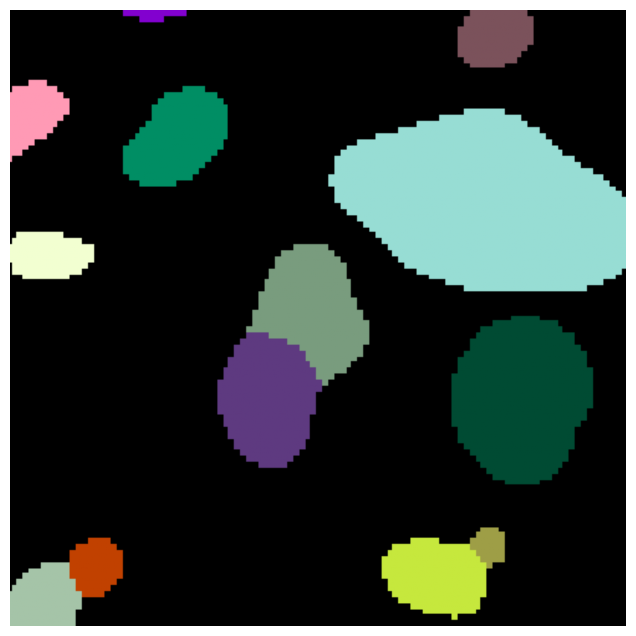

In [115]:
import matplotlib.patches as mpatches

ztoshow = 0
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(fullrgbim[ztoshow], interpolation='nearest')
rect = mpatches.Rectangle((y_min, x_min), y_max - y_min, x_max - x_min, fill=False, edgecolor='red', linewidth=2)
ax.add_patch(rect)
ax.set_axis_off()
# imtoshow = forims

plt.imshow(fullrgbim[ztoshow, x_min:x_max, y_min:y_max])
plt.axis('off')
print(f'Labels in stack {ztoshow}: {np.unique(plot_masks[:, :, ztoshow])}')
print(f'Labels in entire image: {np.unique(plot_masks)}')

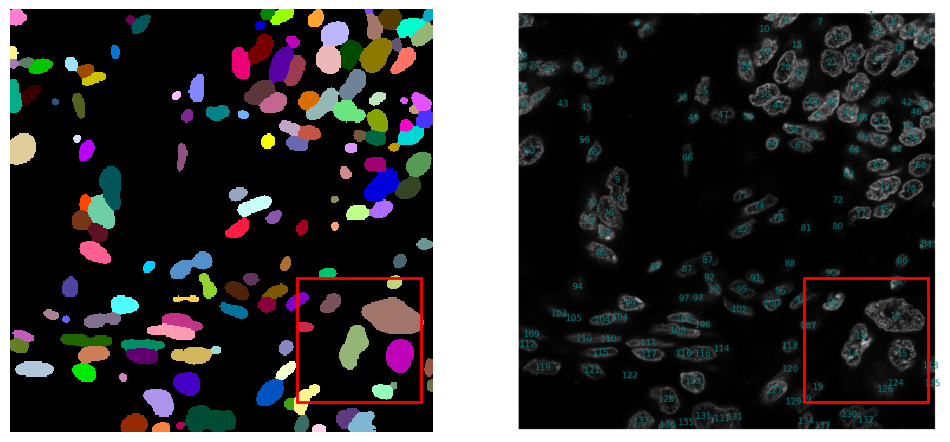

In [149]:
# For spot checking against labels
fig, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].imshow(fullrgbim[ztoshow],interpolation='nearest')
rect = mpatches.Rectangle((y_min, x_min), y_max - y_min, x_max - x_min, fill=False, edgecolor='red', linewidth=2)
ax[0].add_patch(rect)
ax[0].set_axis_off()
#
# ax[1].add_patch(rect)
rect2 = mpatches.Rectangle((y_min, x_min), y_max - y_min, x_max - x_min, fill=False, edgecolor='red', linewidth=2)
ax[1].imshow(imstack['numbered'][ztoshow])
ax[1].add_patch(rect2)
ax[1].set_axis_off()
#
# plt.tight_layout()
# # Color checking a specific label
# import matplotlib.patches as mpatches
#
# labid = 61
# someX, someY = 0.5, 0.5
# fig,ax = plt.subplots()
# currentAxis = plt.gca()
# currentAxis.add_patch(mpatches.Rectangle((someX - 0.1, someY - 0.1), 0.2, 0.2,
#                                 alpha=1, facecolor=matplotlib.colors.to_rgba(hexdict[labid])))

--- 116.0 seconds ---


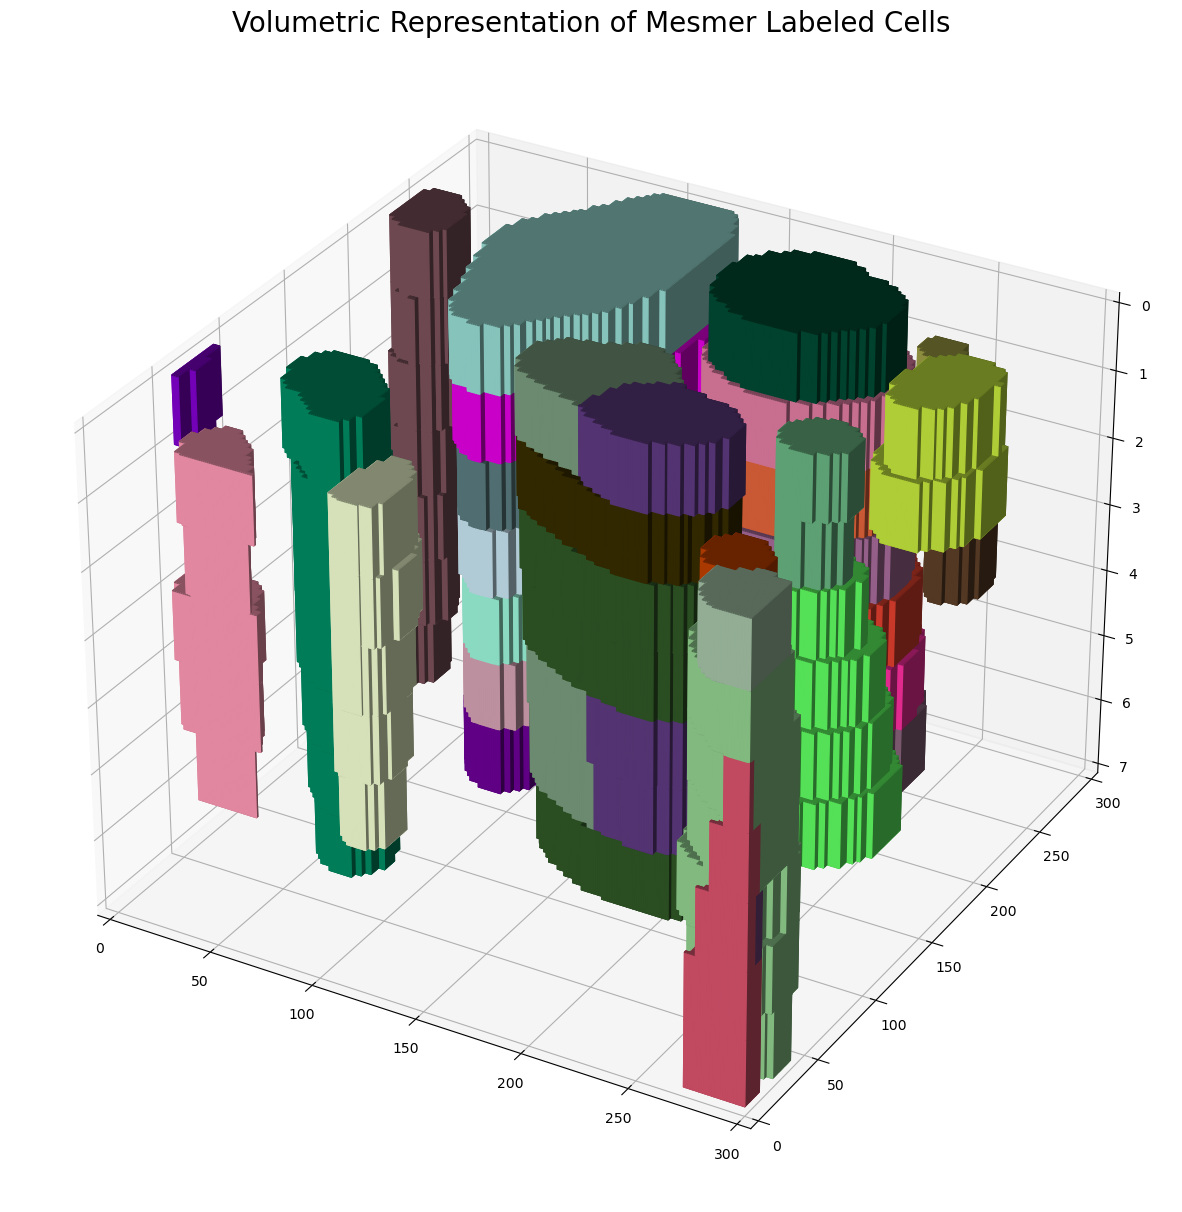

In [116]:
### Create Volumetric Image
# at this point: newcols is the list of colors as hex labels, plot_masks is the image to plot with the labels as numbers.
# Need to make a 3dimensional map of the colors using the labels being plotted to pass to the volumetric plotting.
# Need to set none for background images.

ndcolstopass = np.empty(plot_masks.shape, dtype='<U9')

for label, i in enumerate(newcols):
    if label in plot_masks:
        # print(f"Label: {label}, RGBA Hex: {i}")
        if label == 0:
            voxcol = None
        else:
            voxcol = i
        ndcolstopass = np.where(plot_masks == label, voxcol, ndcolstopass)

start_time = time.time()

fig = plt.figure(figsize=(15, 25))

# Predicted Cell volumes
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(0, projectxydims)
ax.set_ylim3d(0, projectxydims)
ax.set_zlim3d(z_max, z_min)

ax.voxels(plot_masks,
          facecolors=ndcolstopass,
          edgecolors=ndcolstopass,
          )
ax.set_title('Volumetric Representation of Mesmer Labeled Cells', fontsize = 20)
print("--- %s seconds ---" % round((time.time() - start_time), 0))
plt.show()

## My Cell Tracker 3D

In [117]:
# Loop to run single image through all
runtest = True # 72 seconds
# runtest = False

df = testgroup

start_time = time.time()
if runtest:
    for i in df.index:
        imgfile = df['imagepath'][i]
        imgname = df['imgfolder'][i]
        fakemem = df['gappath'][i]
        print('Starting:',imgname)

        # for running Mesmer
        nuc_channel = imread(imgfile, plugin='tifffile')
        mem_channel = imread(fakemem, plugin='tifffile')

        # Required to have 4 dimensions: [batch, x, y, channel], with nuclear channel first and cytoplasmic channel second."
        im = np.stack((nuc_channel, mem_channel), axis=-1)
        app = Mesmer()
        meslabel = app.predict(im,image_mpp = 0.175,compartment='nuclear')
        nuc = np.expand_dims(nuc_channel, axis=-1)

        forwardlabeldict = CreateMesmerLabelDictv01(imgfile, nucfinal)
        reverselabeldict = CreateMesmerLabelDictv01(imgfile, nucfinal, reverse_direction = True)
        newlabelsforward = CellTrackerv04(forwardlabeldict)
        newlabelsreverse = CellTrackerv04(reverselabeldict)


print("--- %s seconds ---" % round((time.time() - start_time),0))

Starting: C1-FB323A_CSC_Rd1_11


--- 69.0 seconds ---


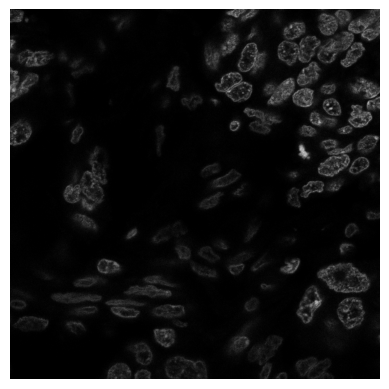

In [118]:
showtif(newlabelsforward['images']['z2'])

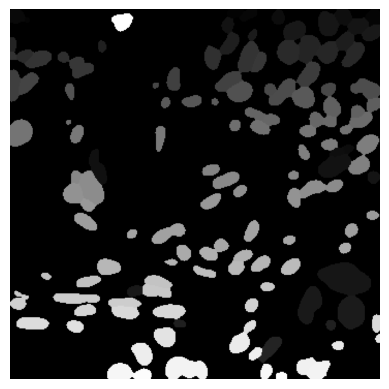

In [119]:
showtif(newlabelsforward['labels']['z2'])

In [2]:
## Forward direction
imstack = StackCreatorv02(newlabelsforward)
dftoqc = newlabelsforward

uniquelabs = []
for i in dftoqc['labels'].keys():
    for j in np.unique(dftoqc['labels'][i]):
        uniquelabs.append(j)
print(len(np.unique(uniquelabs)), np.max(uniquelabs))

uniqueprops = []
for i in dftoqc['props'].keys():
    for j in np.unique(dftoqc['props'][i].label):
        uniqueprops.append(j)
print(len(np.unique(uniqueprops)), np.max(uniqueprops))

Counter(uniqueprops) == Counter([value for value in uniquelabs if value != 0])

# From stackcreator function. Creates a random color for each label that can be referenced throughout the stack. Format is in RGB (3 columns per label, each value is between 0 and 1).

uniquelabs = np.unique(uniquelabs)
# Create the color map for all of the unique labels.
randcols = np.random.random((len(uniquelabs), 3))
# Set background labels as 0
randcols[0] = 0
print(len(uniquelabs))
len(randcols)
# randcols
pal = sns.color_palette(cc.glasbey, n_colors=len(uniquelabs), as_cmap=True)
pal[0] = '#000000'
print(len(pal))
sns.palplot(pal)
# Create a separate stack from just the label images (pull them from the dictionary)
newstack = []
for i in dftoqc['labels']:
    newstack.append(dftoqc['labels'][i])
forims = np.stack(newstack)
forims.shape
len(np.unique(forims))
# Make a colormap for matplotlib from the random colors generated.
mycmap = matplotlib.colors.ListedColormap(pal)  # randcols
# mycmap

# Convert the label colors to rgba values represented as hex codes (necessary for the ax3d to read them).
# Output is a list with each value being the hex code for the rgba value associated with the label, includes all values in the original image.

newcols = np.empty(uniquelabs.shape, dtype='<U9')
for i in uniquelabs:
    rgba = matplotlib.colors.rgb2hex(mycmap(i), keep_alpha=True)
    newcols = np.where(uniquelabs == i, rgba, newcols)
# newcols
hexdict = {}
for idx, hex in enumerate(pal):
    hexdict[idx] = hex
# hexdict
imtoshow = forims

rgbdict = {}
for col in hexdict.keys():
    rgbdict[col] = matplotlib.colors.hex2color(hexdict[col])

hstacks = []
for val in rgbdict.values():
    hstacks.append(np.hstack(val))
rgbstacks = np.stack(hstacks)

r = np.empty((imtoshow.shape[1], imtoshow.shape[2]))
g = np.empty((imtoshow.shape[1], imtoshow.shape[2]))
b = np.empty((imtoshow.shape[1], imtoshow.shape[2]))

for idx, red in enumerate(rgbstacks[:, 0]):
    r = np.where(imtoshow == idx, red, r)
for idx, green in enumerate(rgbstacks[:, 1]):
    g = np.where(imtoshow == idx, green, g)
for idx, blue in enumerate(rgbstacks[:, 2]):
    b = np.where(imtoshow == idx, blue, b)

fullrgbim = np.stack((r, g, b), axis=3)

fullrgbim.shape
# Take a small piece of the full image to make 3D (full image takes a very long time to create)

projectbw = forims.copy()
projectxydims = 300

x_min = np.random.randint(0, projectbw.shape[1] - projectxydims)
x_max = x_min + projectxydims
y_min = np.random.randint(0, projectbw.shape[2] - projectxydims)
y_max = y_min + projectxydims

# For Setting custom coordinates:
# y_min = 512
# y_max = 912
# x_min = 423
# x_max = 823
# dims 300
# y_min = 481
# y_max = 781
# x_min = 358
# x_max = 658
y_min = 695
y_max = 995
x_min = 650
x_max = 950

z_min = 0
z_max = projectbw.shape[0] + z_min
masks = projectbw[z_min:z_max, x_min:x_max, y_min:y_max]
plot_masks = np.rollaxis(np.squeeze(masks), 0, 3)

print(plot_masks.shape)
print(y_min, y_max, x_min, x_max)

NameError: name 'StackCreatorv02' is not defined

NameError: name 'StackCreatorv02' is not defined

Labels in stack 0: [  0  12  14  15  19  90  93  98 101 107 124 126]
Labels in entire image: [  0  12  14  15  18  19  90  93  98 101 107 124 126 129 141 144]


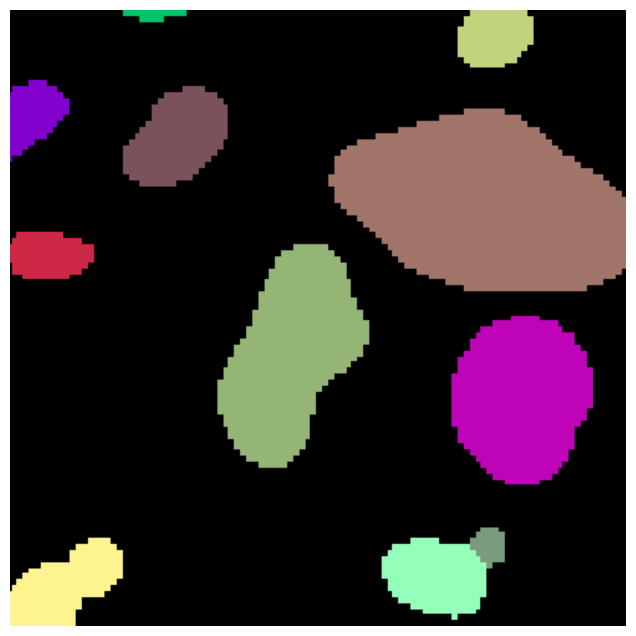

In [121]:
import matplotlib.patches as mpatches

ztoshow = 0
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(fullrgbim[ztoshow], interpolation='nearest')
rect = mpatches.Rectangle((y_min, x_min), y_max - y_min, x_max - x_min, fill=False, edgecolor='red', linewidth=2)
ax.add_patch(rect)
ax.set_axis_off()
# imtoshow = forims

plt.imshow(fullrgbim[ztoshow, x_min:x_max, y_min:y_max])
plt.axis('off')
print(f'Labels in stack {ztoshow}: {np.unique(plot_masks[:, :, ztoshow])}')
print(f'Labels in entire image: {np.unique(plot_masks)}')

In [122]:
forwardlabeldict.keys()

dict_keys(['images', 'labels', 'props'])

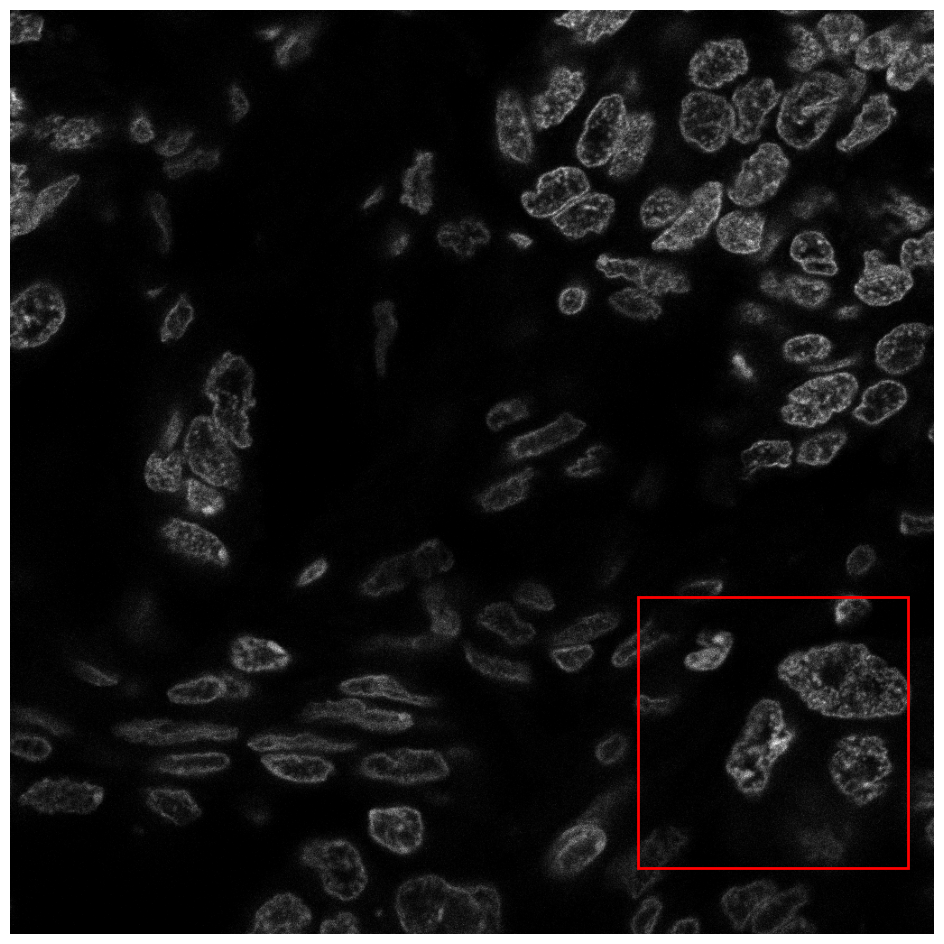

In [123]:
fig, ax = plt.subplots(1,figsize=(12,12))
ax.imshow(forwardlabeldict['images']['z0'], cmap='gray')
rect = mpatches.Rectangle((y_min, x_min), y_max - y_min, x_max - x_min, fill=False, edgecolor='red', linewidth=2)
ax.add_patch(rect)
ax.set_axis_off()

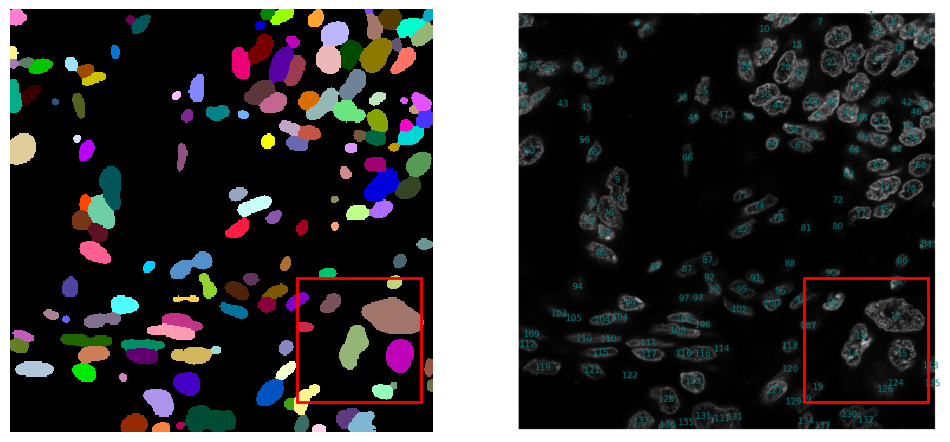

In [148]:
# For spot checking against labels
fig, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].imshow(fullrgbim[ztoshow],interpolation='nearest')
rect = mpatches.Rectangle((y_min, x_min), y_max - y_min, x_max - x_min, fill=False, edgecolor='red', linewidth=2)
ax[0].add_patch(rect)
ax[0].set_axis_off()
#
# ax[1].add_patch(rect)
rect2 = mpatches.Rectangle((y_min, x_min), y_max - y_min, x_max - x_min, fill=False, edgecolor='red', linewidth=2)
ax[1].imshow(imstack['numbered'][ztoshow])
ax[1].add_patch(rect2)
ax[1].set_axis_off()
#
# plt.tight_layout()
# # Color checking a specific label
# import matplotlib.patches as mpatches
#
# labid = 61
# someX, someY = 0.5, 0.5
# fig,ax = plt.subplots()
# currentAxis = plt.gca()
# currentAxis.add_patch(mpatches.Rectangle((someX - 0.1, someY - 0.1), 0.2, 0.2,
#                                 alpha=1, facecolor=matplotlib.colors.to_rgba(hexdict[labid])))

--- 123.0 seconds ---


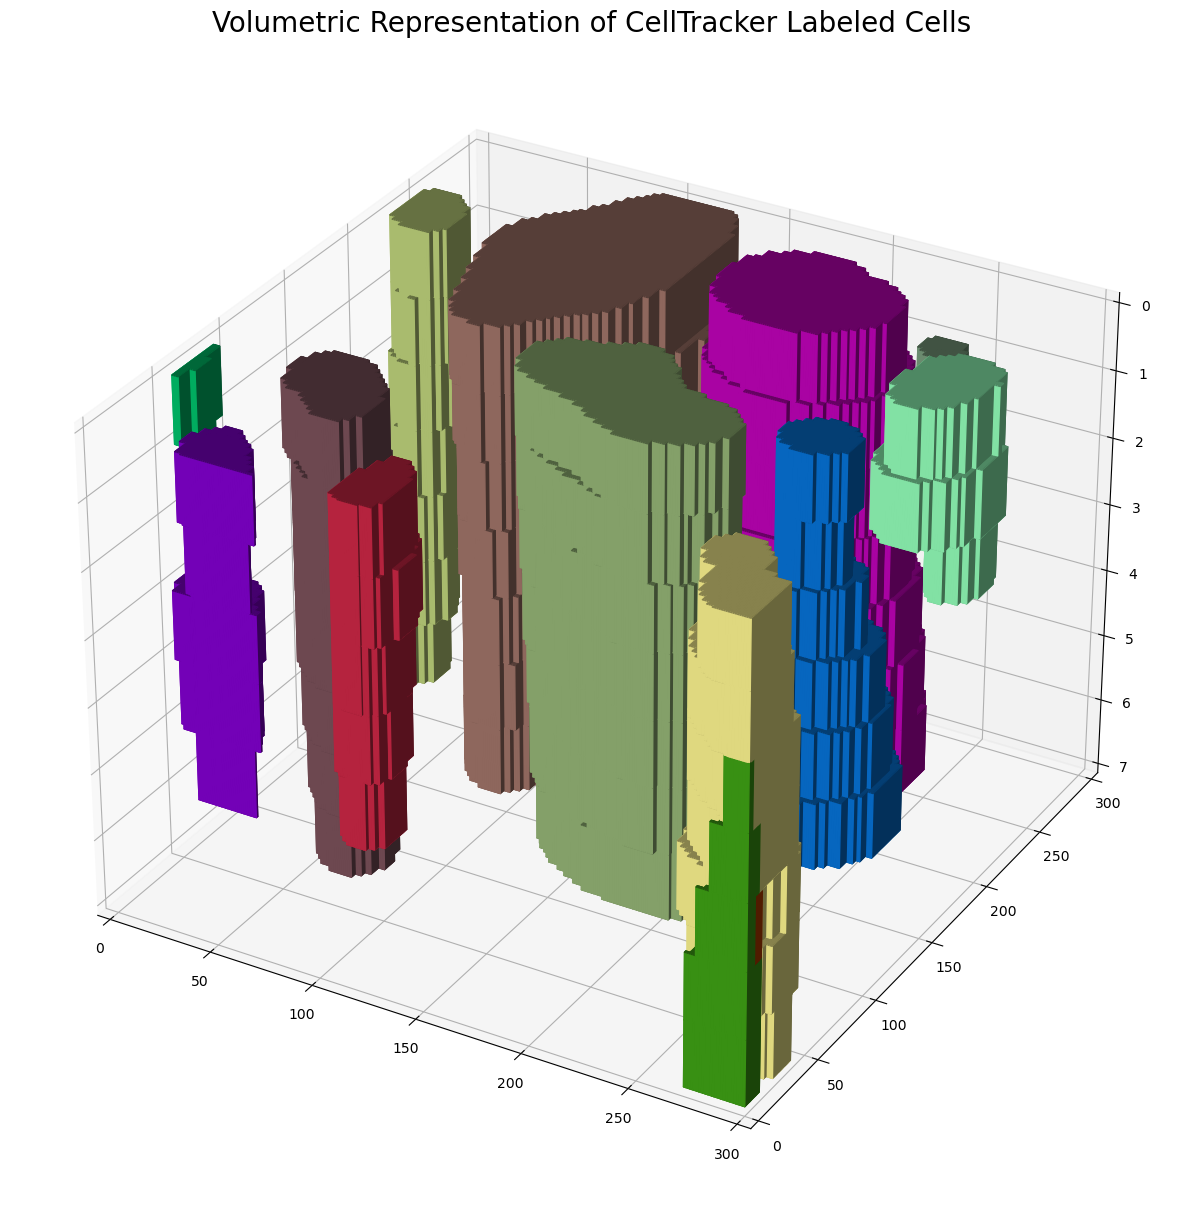

In [124]:
### Create Volumetric Image
# at this point: newcols is the list of colors as hex labels, plot_masks is the image to plot with the labels as numbers.
# Need to make a 3dimensional map of the colors using the labels being plotted to pass to the volumetric plotting.
# Need to set none for background images.

ndcolstopass = np.empty(plot_masks.shape, dtype='<U9')

for label, i in enumerate(newcols):
    if label in plot_masks:
        # print(f"Label: {label}, RGBA Hex: {i}")
        if label == 0:
            voxcol = None
        else:
            voxcol = i
        ndcolstopass = np.where(plot_masks == label, voxcol, ndcolstopass)

start_time = time.time()

fig = plt.figure(figsize=(15, 25))

# Predicted Cell volumes
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(0, projectxydims)
ax.set_ylim3d(0, projectxydims)
ax.set_zlim3d(z_max, z_min)

ax.voxels(plot_masks,
          facecolors=ndcolstopass,
          edgecolors=ndcolstopass,
          )
ax.set_title('Volumetric Representation of CellTracker Labeled Cells', fontsize = 20)
print("--- %s seconds ---" % round((time.time() - start_time), 0))
plt.show()

# Making GIFs

## Raw Input Image

C1-FB323A_CSC_Rd1_11
dict_keys(['images', 'labels', 'props'])


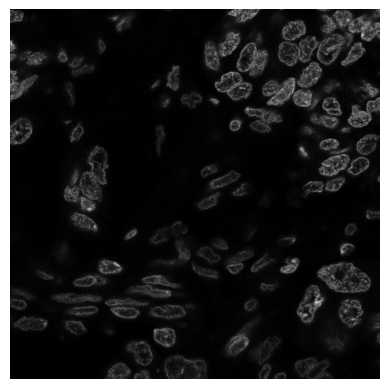

In [130]:
i = 10

testgroup = imgdf.iloc[[i]].copy()
df = testgroup
for i in df.index:
    imagename = df['imgfolder'][i]
    labelimage = meslabel[...,0]
    origlabeldict = CreateMesmerLabelDictv01(imgfile, labelimage)

print(imagename)
print(origlabeldict.keys())
showtif(origlabeldict['images']['z0'])

In [134]:
output_name = 'test'
output_directory =  OUTDIR
savegif = False
savegif = True
savetiff = False

In [144]:
# input_stack = origlabeldict['images']
# if savegif:
#     filenames = []
#     for i in range(input_stack.shape[0]):
#         fig, ax = plt.subplots(figsize=(10,10))
#         ax.imshow(input_stack[i])
#         ax.axis('off')
#         plt.tight_layout(pad=0)
#
#         filename = os.path.join(output_directory, f'temp_{i}.tiff')
#         filenames.append(filename)
#         plt.savefig(filename)
#         plt.close(fig)
#     # Create the GIF from the saved images.
#     fp_in = os.path.join(output_directory,"temp_*.tiff")
#     fp_out = os.path.join(output_directory,f"{output_name}.gif")
#     imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
#     img = next(imgs)
#     # extract first image from iterator
#     img.save(fp=fp_out, format='GIF', append_images=imgs,
#              save_all=True, duration=200, loop=0)
#     for filename in set(filenames):
#         os.remove(filename)

In [136]:
def StackCreatorv02(input_dict):
    """Creates a dictionary of tifs based on the labels of the input dictionary. Dictionary needs to contain the keys 'labels', 'props', and 'images'. Use the CreateLabelDict function for this purpose. The returned dictionary contains a tif that is colored only by its label (shaded), a tif with the label number overlaid on top of each stack (numbered), and a tif that is colored based using a randomized colormap (colored)."""
    stackdict = {}
    # Find all of the unique labels contained in all the label images.
    uniquelabs = []
    for i in input_dict['labels'].keys():
        for j in np.unique(input_dict['labels'][i]):
            uniquelabs.append(j)
    uniquelabs = np.unique(uniquelabs)

    # Create the color map for all of the unique labels.
    pal = sns.color_palette(cc.glasbey, n_colors=len(uniquelabs), as_cmap=True)
    # Set background labels as 0
    pal[0] = '#000000'

    hexdict = {}
    for idx,hex in enumerate(pal):
        hexdict[idx]=hex

    newstack = []
    for i in input_dict['labels']:
        newstack.append(input_dict['labels'][i])
    imtoshow = np.stack(newstack)

    rgbdict = {}
    for col in hexdict.keys():
        rgbdict[col]=matplotlib.colors.hex2color(hexdict[col])

    hstacks = []
    for val in rgbdict.values():
        hstacks.append(np.hstack(val))
    rgbstacks = np.stack(hstacks)

    r = np.empty((imtoshow.shape[1], imtoshow.shape[2]))
    g = np.empty((imtoshow.shape[1], imtoshow.shape[2]))
    b = np.empty((imtoshow.shape[1], imtoshow.shape[2]))

    for idx,red in enumerate(rgbstacks[:,0]):
        r = np.where(imtoshow==idx, red,r)
    for idx,green in enumerate(rgbstacks[:,1]):
        g = np.where(imtoshow==idx, green,g)
    for idx,blue in enumerate(rgbstacks[:,2]):
        b = np.where(imtoshow==idx, blue,b)

    fullrgbim = np.stack((r,g,b), axis=3)

    # Create a stack of the numbered labels
    numlabels = []
    for h in input_dict['labels']:
        xsize = input_dict['labels'][h].shape[0]/100
        ysize = input_dict['labels'][h].shape[1]/100
        fig, ax = plt.subplots(figsize=(xsize,ysize),dpi=100)
        ax.imshow(input_dict['images'][h], cmap='gray')
        for i in input_dict['props'][h].index:
            x = input_dict['props'][h].iloc[i]["centroid-0"]
            y = input_dict['props'][h].iloc[i]["centroid-1"]
            text = input_dict['props'][h].iloc[i]["label"].astype(int)
            ax.text(y, x, text, dict(color='teal', va='center', ha='center', size = 15))
        ax.axis('off')
        plt.tight_layout(pad=0)
        fig.canvas.draw()
        numz = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        numz = numz.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        numlabels.append(numz)
        plt.close(fig)
    numberedstack = np.stack(numlabels)

    # Create a stack of the shaded labels
    shadedlabels =[]
    for i in input_dict['labels']:
        xsize = input_dict['labels'][i].shape[0]/100
        ysize = input_dict['labels'][i].shape[1]/100
        fig, ax = plt.subplots(figsize=(xsize,ysize),dpi=100)
        ax.imshow(input_dict['labels'][i], cmap='gray')
        ax.axis('off')
        plt.tight_layout(pad=0)
        fig.canvas.draw()
        shadez = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        shadez = shadez.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        shadedlabels.append(shadez)
        plt.close(fig)
        # shadedlabels.append(input_dict['labels'][i])
    shadedstack = np.stack(shadedlabels)

    # Save the outputs together to a dictionary.
    stackdict['shaded']=shadedstack
    stackdict['colored']=fullrgbim
    stackdict['numbered']=numberedstack
    return stackdict

In [142]:
def OutputWriterv03(input_stack, output_name, output_directory, savegif = True, savetiff = True):
    if savegif:
        filenames = []
        for i in range(input_stack.shape[0]):
            fig, ax = plt.subplots(figsize=(10,10))
            ax.imshow(input_stack[i], cmap='gray')
            ax.axis('off')
            plt.tight_layout(pad=0)

            filename = os.path.join(output_directory, f'temp_{i}.tiff')
            filenames.append(filename)
            plt.savefig(filename)
            plt.close(fig)
        # Create the GIF from the saved images.
        fp_in = os.path.join(output_directory,"temp_*.tiff")
        fp_out = os.path.join(output_directory,f"{output_name}.gif")
        imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
        img = next(imgs)  # extract first image from iterator
        img.save(fp=fp_out, format='GIF', append_images=imgs,
                 save_all=True, duration=200, loop=0)
        for filename in set(filenames):
            os.remove(filename)
    if savetiff:
        pilimages = []
        for i in range(input_stack.shape[0]):
            updatedstack = input_stack[i]*255
            updatedstack = updatedstack.astype(np.uint8)
            new = Image.fromarray(updatedstack)
            pilimages.append(new)
        outname = os.path.join(output_directory,f"{output_name}.tiff")
        pilimages[0].save(outname,format='TIFF',save_all=True,append_images=pilimages[1:])

In [145]:
output_name = imagename+'_raw'
output_directory =  OUTDIR
savegif = False
savegif = True
savetiff = False

In [146]:
dictforgif = []
for i in origlabeldict['images']:
    dictforgif.append(origlabeldict['images'][i])
dictforgif = np.stack(dictforgif)

In [147]:
OutputWriterv03(dictforgif,output_name=output_name, output_directory=output_directory,savegif=True,savetiff=False)